# <mark> Root Doc Extraction -  Soluçao de Extracao de NFS-e por estabelecimento de pipeline </mark>

<b>0_root_doc_extract_v0.ipynb</b> |  Atual notebook com as funçoes para processamento de PDF Pesquisavel e Raster e a criaçao dos Dataframes de forma dependente e unica

### Modules & config

In [7]:
import os
import sys
import shutil
import platform
from io import StringIO
from pathlib import Path
from urllib import response

from outlook_msg import Message
import extract_msg
import zipfile
from pyunpack import Archive
import py7zr

import re
from unidecode import unidecode
from unicodedata import normalize
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import PyPDF2

import csv
import json
import pandas as pd

import uuid
import hashlib

import locale
import time, copy
from pytz import timezone
from datetime import datetime, timezone, timedelta

import cv2
import fitz  # Módulo PyMuPDF
from PIL import Image
from PIL import ImageFont
from PIL import Image, ImageDraw
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

import pytesseract

# Modulos da solucao
# import modules.extrai_pdf_pesquisavel as Extc
import modules.cronometro as cron
import modules.nova_extracao_pdf_pesquisavel as novaextra 

In [8]:
#### Config - E-mail
# 1. Caminho do arquivo uma mensagem especifica
msg_dir_path = 'pipeline_extracao_documentos/1_emails_documentos_recebidos/11_emails'

# 2. Path para arquivos atachados compactados
msg_attachment_zip = 'pipeline_extracao_documentos/1_emails_documentos_recebidos/13_attachments'


#### Config - messages
# 3. Caminho do arquivo uma mensagem especifica
msg_outros_path = 'pipeline_extracao_documentos/1_emails_documentos_recebidos/12_messages'

# 4. Path para arquivos recebidos manualmente
arquivos_recebidos_path = 'pipeline_extracao_documentos/1_emails_documentos_recebidos/14_documentos_recebidos'


####Config Processamento Pipeline

# 5. Path para documentos para extracao
documentos_extracao_path = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento"

# 6. Path para gestao de imagens resized
image_resized_path = "pipeline_extracao_documentos/6_geral_administacao/temp_docs/images/processadas"



# 7. path para arquivos json
json_path = "pipeline_extracao_documentos/5_documentos_processados/jsons"

# 7. Path para DFs e CSVs exportados
export_path = "pipeline_extracao_documentos/6_geral_administacao/exports"

# 8. Path para lixeira
root_garbage_path = "pipeline_extracao_documentos/0_lixeira"


#### paths de objetos para criacao/gestao (dicionarios/datasets)
cnae_dict_path = "pipeline_extracao_documentos/6_geral_administacao/datasets/CNAE_X_ITEM_SERVICO_PREFEITURAS.xlsx"


# 12. poppler path
poppler_path = "/home/dani-boy/miniconda3/envs/tables-detr/bin"

# 13. path para config Tesseract
#tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6'

#Modelo atual
#tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6'

# definindo localizadcao para pt_BR
locale.setlocale(locale.LC_TIME, "pt_BR.utf8")

'pt_BR.utf8'

### Parte 1 - Funcoes para e-mail e extracao (rever)

In [3]:
# 1. Geraçao do hash do arquivo
def generate_file_hash(file_path):
    # Abre o arquivo em modo de leitura de bytes
    with open(file_path, "rb") as f:
        # Lê o conteúdo do arquivo
        file_data = f.read()
        # Utiliza o algoritmo SHA-256 para gerar o hash
        file_hash = hashlib.sha256(file_data).hexdigest()
    return file_hash

# 2. Geraçao do Unique_id do arquivo
def generate_unique_id():
    return str(uuid.uuid4())

# 3. XXX Busca proximo Batch
def busca_proximo_batch():
    # Abre o arquivo Excel e lê a coluna 'batch'
    df = pd.read_excel("pipeline_extracao_documentos/6_geral_administacao/exports/df_documento_recebido.xlsx", usecols=["batch"])
    # Pega o último valor da coluna 'batch'
    last_value = df.iloc[-1, 0]
    
    # Extraí o número do último batch e adiciona 1 para o próximo
    last_number = int(last_value.split("_")[1])
    next_number = last_number + 1
    
    # Forma o nome do próximo batch
    next_batch = f"Batch_{next_number}"
    
    return next_batch    

# 4. Função para verificar e criar a pasta se não existir
def check_and_create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
# 5. converte nome do arquivo
def conv_filename(title):
    
    # Divide o título em nome e extensão
    name, extension = title.rsplit('.', 1) if '.' in title else (title, "")

    # Remove acentos e caracteres especiais do nome
    name = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    # Substiti espaços e hífens por sublinhados
    filename = name.replace(' ', '_').replace('-', '_')

    # Remove quaisquer outros caracteres não alfanuméricos, exceto sublinhados
    filename = re.sub(r'[^\w_]', '', filename)

    # Converte para minúsculas
    filename = filename.lower()

    # Adiciona a extensão de volta, se houver
    if extension:
        filename += '.' + extension.lower()

    return filename

# 6. converte nome do arquivo retirando extensao
def conv_filename_no_ext(title):
    
    # Divida o título em nome e extensão (mas ignore a extensão)
    name = title.rsplit('.', 1)[0] if '.' in title else title

    # Remova acentos e caracteres especiais do nome
    name = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    # Substitua espaços e hífens por sublinhados
    filename = name.replace(' ', '_').replace('-', '_')

    # Remova quaisquer outros caracteres não alfanuméricos, exceto sublinhados
    filename = re.sub(r'[^\w_]', '', filename)

    # Converter para minúsculas
    filename = filename.lower()

    return filename         

# 7. funçao que MOVE documentos e gera add_log_transaction_entry para df_log_transctions
def move_doc_processed_file(batch_name, src_path, tgt_path):
    
    function = "move_doc_processed_file"
    source_path = src_path
    file = os.path.basename(source_path)
    sub_dir = os.path.join(tgt_path, batch_name)
    destination_path = os.path.join(sub_dir, file)
    document_action = "move_processed_file"
    transaction_detail = (f'document {file} moved by: {function}')
    df_move = pd.DataFrame()
    try:
        document_unique_id = get_document_id_by_file(batch_name, file)
        check_and_create_folder(destination_path)
        shutil.move(source_path, destination_path)
        sucess = True
        move_log = add_log_transaction_entry(document_unique_id, batch_name, file, document_action, src_path, tgt_path, transaction_detail, sucess)
    except Exception as e:
        print(f"Erro ao mover documento: {e}")
        sucess = False
    
    return move_log    

# 8. Função para adicionar um novo registro em df_source
def add_source_entry(batch_name, file_path, file, type, level, parent_unique_id):
    #unique_id = generate_unique_id(type)
    unique_id = generate_unique_id()
    time_now = cron.timenow_pt_BR()   
    file_hash = generate_file_hash(file_path) 
    if level == 1:
        parent_unique_id = unique_id
    data = {
        'Batch': batch_name,
        'Data': time_now,
        'File': file,
        'Type': type,
        'Level': level,
        'Unique_ID': unique_id,
        'Parent_Unique_ID': parent_unique_id,
        'Hash': file_hash,
        'File_Path': file_path
    }
    return data

# 9. Add nova linha para atualizar df_log_transctions
def add_log_transaction_entry(document_unique_id,batch_name, file, document_action, src_path, tgt_path, transaction_detail, sucess=True):

    data_log = {
        'Dt_Time': cron.timenow_pt_BR(),
        'Batch': batch_name,
        'File' : file,
        'Unique_ID': document_unique_id,
        'Action': document_action,
        'Sorce': src_path,
        'Target': tgt_path,
        'Transction_Detail': transaction_detail,
        'Sucess': sucess,    
    }
    
        
    return data_log


# 10. Consulta multiparametros
def filtrar_df(df, **kwargs):
    query = " & ".join(f"{key} == @kwargs['{key}']" for key in kwargs)
    result = df.query(query)
    return result

# 11. Pesquiso Unique_ID por file
def get_document_id_by_file(batch, file):
    
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    
    return document_unique_id


# 12. Busca filhos - simples
def get_children(batch, file_path):
    
    file = os.path.basename(file_path)
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    # Buscando todos dos filhos de um documento
    return filtrar_df(df_id_relations, Batch=batch, Parent_Unique_ID=document_unique_id)


# 13. Busca pai -simples
def get_father(batch, file_path):
    
    file = os.path.basename(file_path)
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    parent_unique_id = result['Parent_Unique_ID'].values[0]
    # Buscando todos dos filhos de um documento
    return filtrar_df(df_id_relations, Batch=batch, Unique_ID=parent_unique_id)


# 14. Pesquiso pai pelo Unique_ID e trago um dict
def get_father_data_by_children_file(batch, file):
    
    src_result = filtrar_df(df_id_relations, Batch=batch, File=file)
    src_parent_unique_id = src_result['Parent_Unique_ID'].values[0]
    result = filtrar_df(df_id_relations, Batch=batch, Unique_ID=src_parent_unique_id)
    document_batch = result['Batch'].values[0]
    document_data = result['Data'].values[0]
    document_file = result['File'].values[0]
    document_type = result['Type'].values[0]
    document_level = result['Level'].values[0]
    document_unique_id = result['Unique_ID'].values[0]
    document_parent_unique_id = result['Parent_Unique_ID'].values[0]
    document_hash = result['Hash'].values[0]
    document_file_path = result['File_Path'].values[0]
    
    return {
        'Batch': document_batch, 
        'Data': document_data,
        'File' : document_file,
        'Type': document_type,
        'Level': document_level,
        'Unique_ID': document_unique_id,
        'Parent_Unique_ID': document_parent_unique_id,
        'Hash': document_hash,
        'File_Path': document_file_path,
    }


# 15. Pesquiso pai pelo Unique_ID (document_parent_unique_id) e cria DICT
def get_father_by_unique_id(batch, document_parent_unique_id):
    
    result = filtrar_df(df_id_relations, Batch=batch, Unique_ID=document_parent_unique_id)
    document_batch = result['Batch'].values[0]
    document_data = result['Data'].values[0]
    document_file = result['File'].values[0]
    document_type = result['Type'].values[0]
    document_level = result['Level'].values[0]
    document_unique_id = result['Unique_ID'].values[0]
    document_parent_unique_id = result['Parent_Unique_ID'].values[0]
    document_hash = result['Hash'].values[0]
    document_file_path = result['File_Path'].values[0]
    
    return {
        'Batch': document_batch, 
        'Data': document_data,
        'File' : document_file,
        'Type': document_type,
        'Level': document_level,
        'Unique_ID': document_unique_id,
        'Parent_Unique_ID': document_parent_unique_id,
        'Hash': document_hash,
        'File_Path': document_file_path,
    }
    
# 16. Pesquiso pai pelo file do filho e cria DICT
def get_father_data_by_children_file(batch, file):
    
    src_result = filtrar_df(df_id_relations, Batch=batch, File=file)
    src_parent_unique_id = src_result['Parent_Unique_ID'].values[0]
    result = filtrar_df(df_id_relations, Batch=batch, Unique_ID=src_parent_unique_id)
    document_batch = result['Batch'].values[0]
    document_data = result['Data'].values[0]
    document_file = result['File'].values[0]
    document_type = result['Type'].values[0]
    document_level = result['Level'].values[0]
    document_unique_id = result['Unique_ID'].values[0]
    document_parent_unique_id = result['Parent_Unique_ID'].values[0]
    document_hash = result['Hash'].values[0]
    document_file_path = result['File_Path'].values[0]
    
    return {
        'Batch': document_batch, 
        'Data': document_data,
        'File' : document_file,
        'Type': document_type,
        'Level': document_level,
        'Unique_ID': document_unique_id,
        'Parent_Unique_ID': document_parent_unique_id,
        'Hash': document_hash,
        'File_Path': document_file_path,
    }        
        

# 17. Busca o 'Unique_ID' para definir o Parent_Unique_ID sem considerar 'Level'
def get_parent_unique_id(df_id_relations, batch_name, file, type):
    try:
        parent_unique_id = df_id_relations[(df_id_relations['Batch'] == batch_name) & (df_id_relations['File'] == file) & (df_id_relations['Type'] == type)]['Unique_ID'].values[0]
    except IndexError:
        parent_unique_id = None
        print(f"Unique_ID para Batch {batch_name} e type: {type} nao encontrado em df_id_relations.")
    return parent_unique_id


# 18. funcao para trazer somente o 'Unique_ID'
def get_document_unique_id(df_id_relations, batch_name, file, type, level):
    try:
        document_unique_id = df_id_relations[(df_id_relations['Batch'] == batch_name) & (df_id_relations['File'] == file) & (df_id_relations['Type'] == type) & (df_id_relations['Level'] == level)]['Unique_ID'].values[0]
    except IndexError:
        document_unique_id = None
        print(f"Unique_ID para Batch {batch_name} e type: {type} nao encontrado em df_id_relations.")
    return document_unique_id


# 19. funcao para trazer somente o 'Parent_Unique_ID'
def get_document_parent_unique_id(df_id_relations, batch_name, file, type, level):
    try:
        document_parent_unique_id = df_id_relations[(df_id_relations['Batch'] == batch_name) & (df_id_relations['File'] == file) & (df_id_relations['Type'] == type) & (df_id_relations['Level'] == level)]['Parent_Unique_ID'].values[0]
    except IndexError:
        document_parent_unique_id = None
        print(f"Unique_ID para Batch {batch_name} e type: {type} nao encontrado em df_id_relations.")
    return document_parent_unique_id


# 20. funçao para trazer toda a row de df_id_relations para o documento
def get_document_id_relations(df_id_relations, batch_name, file, type, level):
    try:
        document_id_relations = df_id_relations[(df_id_relations['Batch'] == batch_name) & (df_id_relations['File'] == file) & (df_id_relations['Type'] == type) & (df_id_relations['Level'] == level)].values[0]
    except IndexError:
        document_id_relations = None
        print(f"Unique_ID para Batch {batch_name} e type: {type} nao encontrado em df_id_relations.")
    return document_id_relations




# EXEMPLOS de Pesquisa DFss
    # get_document_unique_id(df_id_relations, batch_name, file, type, level)

    # # Busca somente o 'Parent_Unique_ID'
    # get_document_parent_unique_id(df_id_relations, batch_name, file, type, level)


    # #Busca todos os dados da row do documento encontrado
    # document_id_relations = get_document_id_relations(df_id_relations, batch_name, file, type, level)

    # document_batch = document_id_relations[0]
    # document_date = document_id_relations[1]
    # document_name = document_id_relations[2]
    # document_type = document_id_relations[3]
    # document_level = document_id_relations[4]
    # document_unique_id = document_id_relations[5]
    # document_parent_unique_id = document_id_relations[6]
    # document_hash = document_id_relations[7]
    # document_path = document_id_relations[8]

    # # Insercao de um registro pela func add_source_entry
    # file_path = "pipeline_extracao_documentos/1_emails_documentos_recebidos/12_attachments/SPA 15082023.rar"

    # file = os.path.basename(file_path)

    # type = "compressed_file_attachment"

    # level = 1

    # parent_unique_id = ''

    # # Adicionando um novo registro (substitua 'batch_name' e 'email' conforme necessário)
    # new_entry = add_source_entry(batch_name, file_path, file, type, level, parent_unique_id)

    # df_id_relations = df_id_relations.append(new_entry, ignore_index=True)

    # df_id_relations


# Busca proximo Batch caso nao esteja rodando email
batch_name = busca_proximo_batch()

# 1. Criaçao do DataFrame para armazenar as relações de Unique_ID e Parent_Unique_ID
df_id_relations = pd.DataFrame(columns=['Batch', 'Data' ,'File', 'Type', 'Level', 'Unique_ID', 'Parent_Unique_ID', 'Hash', 'File_Path'])

# 2. Criaçao do DataFrame para df_start_pipe:
#df_start_pipe = pd.DataFrame(columns=['Batch', 'Data' ,'File', 'Type', 'Level', 'Unique_ID', 'dt_hora', 'de', 'assunto', 'email', 'Hash'])

df_id_relations

,Batch,Data,File,Type,Level,Unique_ID,Parent_Unique_ID,Hash,File_Path


## <mark> <b>2.0</b> Implementando o Root Unique_ID  </mark>

### 2.0.x Template e dicts

In [ ]:
    # templates = {
    #     ("PM_MAGE", "30.693.231/0001-99"): "MAGE_MAICON",
    #     ("PM_MAGE", "23.317.112/0001-76"): "MAGE_MFF",
    #     ("PM_MAGE", "06.083.610/0001-82"): "MAGE_DORIA",      
    #     ("PM_MAGE", None): "MAGE",
    #     ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", "47.945.459/0001-21"): "SAO_PEDRO_GOAT",
    #     ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", "68.687.722/0001-08"): "SAO_PEDRO_GM",
    #     ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", "34.230.979/0038-06"): "SAO_PEDRO_SUPERMIX",
    #     ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", None): "SAO_PEDRO",
    #     ("Pague agora com o seu Pix", None): "NAO_PROCESSAR",
    #     # ... adicione outras combinações aqui
    # }

In [9]:

nf_model_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/frames_nf_v11.xlsx"

# 11. path para datasets CNAE e Itens de Serviço
nf_datasets_path = "pipeline_extracao_documentos/6_geral_administacao/datasets"


#Le a planilha e cria do DF
frames_nf_v4_df = pd.read_excel(nf_model_path)

# Cria dicionários para armazenar diferentes tipos de elementos do modelo
document_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'document'].iloc[0]
boundaries_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'boundaries']
sections_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'section']
frames_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'frame']
sframe_fields_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'sframe_field']
field_boxes_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'field_box']

def define_dados_iniciais(texto_tratado):
    
    dados_iniciais_nf = {}

    prefeitura_encontrada = None
    de_para_encontrado = None

    # 7. ZZZ Dicionário para mapear Prefeitura com sua sigla
    de_para_prefeitura = {
        "PREFEITURA DA CIDADE MAGE": "PM_MAGE",
        "PREFEITURA DA CIDADE DE MAGE": "PM_MAGE",
        "PREFEITURA MUNICIPAL DE MAGE": "PM_MAGE",
        "PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA": "PM_SPA",
        "MUNICIPAL DE SAO PEDRO DA ALDEIA": "PM_SPA",
        "PREFEITURA MUNICIPAL DE MESQUITA": "PM_MESQUITA",
        "PREFEITURA MUNICIPAL DE DE MESQUITA": "PM_MESQUITA",
        # ... adicione 
    }
    

    templates = {
        ("PM_MAGE", None): "MAGE",
        ("Pague agora com o seu Pix", None): "NAO_PROCESSAR",
        # ... adicione outras combinações aqui
    }

    cnpj_encontrado = None
    # Verifique cada linha do texto
    for linha in texto_tratado:
        for pref in de_para_prefeitura.keys():
            if pref in linha:
                #print(linha)
                prefeitura_encontrada = pref
                dados_iniciais_nf['prefeitura'] = prefeitura_encontrada
                #print(prefeitura_encontrada)
    # Saímos do loop, agora vamos verificar qual template usar
    if prefeitura_encontrada:
        de_para_pm = de_para_prefeitura.get(prefeitura_encontrada)
        dados_iniciais_nf['de_para_pm'] = de_para_pm
        #print(de_para_pm)
        if not de_para_pm:
            de_para_pm = de_para_prefeitura.get(prefeitura_encontrada, "NAO_PROCESSAR")
            dados_iniciais_nf['de_para_pm'] = de_para_pm
            #print(de_para_pm)
    else:
        de_para_pm = "NAO_PROCESSAR"
        #print(de_para_pm)
        
        
    # Verifique cada linha do texto
    for linha in texto_tratado:
        for de_para, cnpj in templates.keys():
            if cnpj and cnpj in linha:
                cnpj_encontrado = cnpj
                dados_iniciais_nf['cnpj_encontrado'] = cnpj_encontrado
                
                
    # Saímos do loop, agora vamos verificar qual template usar
    if de_para_pm:
        template_usar = templates.get((de_para_pm, cnpj_encontrado))
        print(f'usara template {template_usar} para: {cnpj_encontrado}')
        # print(template_usar)
        dados_iniciais_nf['template_usar'] = template_usar
        if not template_usar:
            template_usar = templates.get((de_para_pm, None), "TEMPLATE_NAO_ENCONTRADO")
            dados_iniciais_nf['template_usar'] = template_usar 
    else:
        template_usar = "TEMPLATE_NAO_ENCONTRADO"
        dados_iniciais_nf['template_usar'] = template_usar
        
        
    
    #Confirmando se template existe em frames    
    try:        
        f_type = 'frame'
        #template_usar = 'SAO_PEDRO_SUPERMIX'
        result = filtrar_df(frames_nf_v4_df, type=f_type, de_para_pm=de_para_pm, model=template_usar)
        model = result['model'].values[0]
        if model:
            template_oficial = model
            if model == template_usar:
                dados_iniciais_nf['model'] = template_oficial
            else:    
                template_usar = "necessario cadastrar"
                dados_iniciais_nf['template_usar']
                
            dados_iniciais_nf['template_usar'] = template_usar
        else:
            template_usar = "necessario cadastrar"
            dados_iniciais_nf['template_usar'] = template_usar
            dados_iniciais_nf['model'] = template_usar
                
    except Exception as e:
       error_msg = (f"Erro busca cnae: {e}") 
               
        
    return dados_iniciais_nf  



# Dicionário para mapear palavras-chave a rótulos
mapeamento_palavras_chave = {
    "relatorio": "prov_relatorio",
    "listagem": "prov_listagem",
    "NF": "prov_nota_fiscal",
    "nf": "prov_nota_fiscal",
    "relatorio": "prov_listagem",
    "sintetico": "prov_listagem",
    "livro": "prov_livro_registro",
    "sintético": "prov_listagem",
    "nota": "prov_nota_fiscal",
    "zip": "doc_zip",
    "rar": "doc_rar",
    "valores": "prov_dinheiro",
}

# Dicionário mapeando rótulos a ações sugeridas
sugestoes_acao = {
    "prov_relatorio": "NO_PROCESS",
    "prov_listagem": "NO_PROCESS",
    "prov_nota_fiscal": "NO_PROCESS",
    "sem_rotulo": "MANUAL_REV",
    "prov_livro_registro": "NO_PROCESS",
    "doc_nao_pdf": "verificar",
    "nao_pdf": "NO_PROCESS",
    "doc_zip": "NO_PROCESS",
    "pdf_mul_paginas": "SPLIT",
}


def define_rotulo_acao(nome_arquivo):
    
    for palavra_chave, rotulo in mapeamento_palavras_chave.items():
        if palavra_chave.lower() in nome_arquivo.lower():
            break
    else:
        rotulo = 'prov_nota_fiscal' #"sem_rotulo"
        palavra_chave = 'default'
        acao_sugerida = sugestoes_acao.get(rotulo, 'None')
        return palavra_chave, rotulo, acao_sugerida
        # palavra_chave = 'None' #"sem_palavra_chave"
        # acao_sugerida = 'None' #"sem_acao_sugerida"
        
        return palavra_chave, rotulo, acao_sugerida
        #print(f'nome_arquivo: {nome_arquivo} | rotulo: {rotulo}')
    if rotulo != 'None': #"sem_rotulo"
        acao_sugerida = sugestoes_acao.get(rotulo, 'None') # "Ação não definida"
        return palavra_chave, rotulo, acao_sugerida
    
    
# 2.Testando
nome_arquivo = 'batatinha_quando_nasce.pdf' # 'pre-processamento'

palavra_chave, rotulo, acao_sugerida = define_rotulo_acao(nome_arquivo)

print(f'nome_arquivo: {nome_arquivo:>55} | palavra_chave: {palavra_chave:>20} | rotulo: {rotulo:20} | acao_sugerida: {acao_sugerida:30}')    



# 1 XXX Crio o DF  cnae_x_item_servico_df
cnae_x_item_servico_df = pd.read_excel(cnae_dict_path)

# Mapeando prefeitura e CNAE para a descrição do CNAE
cnae_dict = dict(zip(zip(cnae_x_item_servico_df['PREFE'], cnae_x_item_servico_df['CNA_NUMERO']), cnae_x_item_servico_df['CNA_NOME']))

# Mapeando prefeitura e item de serviço para a descrição do item de serviço e o CNAE associado
item_servico_dict = dict(zip(zip(cnae_x_item_servico_df['PREFE'], cnae_x_item_servico_df['ATV_CODIGO']), zip(cnae_x_item_servico_df['ATV_DESCRICAO'], cnae_x_item_servico_df['CNA_NUMERO'])))

nome_arquivo:                              batatinha_quando_nasce.pdf | palavra_chave:              default | rotulo: prov_nota_fiscal     | acao_sugerida: NO_PROCESS                    


In [14]:
frames_nf_v4_df.head()

,id,de_para_pm,cnpj,model,seq,prestador,type,color,f_size,box,...,Largura,Altura,%,x0_p,y0_p,x1_p,y1_p,Largura_p,Altura_p,%_p
0,1,PM_MAGE,v18,MAGE,1,NaN,document,blue,NaN,NaN,...,2067.0,2923.0,NaN,0.0,0.0,600.0,760.0,600.0,760.0,NaN
1,2,PM_MAGE,NaN,MAGE,2,todos,boundaries,green,120.0,yes,...,1781.0,2567.0,100.000000,NaN,NaN,NaN,NaN,0.0,0.0,100.0
2,3,PM_MAGE,NaN,MAGE,3,todos,section,orange,110.0,yes,...,919.0,621.0,24.191663,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,4,PM_MAGE,NaN,MAGE,4,todos,frame,red,100.0,yes,...,1134.0,380.0,NaN,0.0,0.0,600.0,220.0,600.0,205.0,NaN
4,5,PM_MAGE,NaN,MAGE,5,todos,sframe_field,yellow,NaN,no,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [15]:

# 1 Apagar os arquivos PDF:Zone
# apagar_zone(documentos_extracao_path)

batch_name = "Batch_20" #Excepcionalmente
# fake_parent_document_unique_id = generate_unique_id()

nome_formado_json = batch_name +".json"

<mark> ImportaÇao do df_root_pipe </mark>

In [18]:
# 0. XXX SE deseja importar o DF df_analise_pipe

df_root_pipe_path = "processamentos/df_root_analise3.xlsx"


#Le a planilha e cria df_documento_recebido
df_root_pipe = pd.read_excel(df_root_pipe_path)

# Ajusta o indice
df_root_pipe.set_index('document_unique_id', inplace=True)

In [19]:
df_root_pipe

,seq,date_time,batch,fase_processo,nome_atividade,status_documento,acao_executada,original_file_name,directory,one_page,pages,palavra_chave,document_tag,action_item,level,parent_document_unique_id,file_hash,file_path,informations
document_unique_id,,,,,,,,,,,,,,,,,,,
c0079b1e-669e-4140-804c-6f5d880060a5,1,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0297 Raquel.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,f08d5c1e8583a5755cd9b9a328444132fbe127445f6960...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
530cd918-71d7-4f2c-819c-dc7daca355f9,2,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0298 Marcelo.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,88d764f214df1c1c915b8975eeba24d671ca33490e2ef0...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ad325c14-da9b-43df-8e8d-7cf69f83a0c7,3,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0295 Carlos Leandro.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,53305daf18b4e42f36e27a8b900fae3a57cc033b402ba5...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
a34dd6b4-42a3-424c-9c0f-d2314ccbb39c,4,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0300 Vanisa.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,becab429d6ec14ff2e42867f7eb4189bbe09a0c3df7503...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ada25db3-8bcb-4f0c-9ead-2b575d2f51c2,5,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0296 Vanisa (Cancelada).pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,dac71a025f4d2d6b452f31f7573f2d182aee6b6a9f8eda...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
937ed21e-7b9e-4000-ab6a-ffadd90cf2b0,6,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0301 Ultrascan.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,979071adf47addba5183e66c7cb8dc5ab1eec28cc91bb1...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
d4d68cd7-2d50-4178-89fe-b657f9176e39,7,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0299 Luciana.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,789163ae50d04d2b51b12ab3b3423dc2436293f7caf72a...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ee21fe14-0eb1-4ffd-9bf9-124600d0fbf3,8,15/09/2023 13:29:11,Batch_20,analise,scan_analise,root_analise,Analise,Nota Fiscal Eletrônica 188.pdf,1002479,True,1,nota,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,521b11d84bd5e3d113e386d91263bcc959a05b6b48248f...,pipeline_extracao_documentos/2_documentos_para...,NaN
5355a933-346e-4f9c-b3aa-a9a095452e7f,9,15/09/2023 13:29:11,Batch_20,analise,scan_analise,root_analise,Analise,Nota Fiscal Eletrônica 190.pdf,1002479,True,1,nota,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,a12988ff41fe4e851a1c0822c3f05114f81feda117373f...,pipeline_extracao_documentos/2_documentos_para...,NaN


## <mark> <b>2.1</b> Principais Funcoes Utilizadas  </mark>

In [34]:
def filtrar_df(df, **kwargs):
    query = " & ".join(f"{key} == @kwargs['{key}']" for key in kwargs)
    result = df.query(query)
    return result

# 11. Pesquiso Unique_ID por file
def get_document_id_by_file(batch, file):
    
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    
    return document_unique_id


# XXXpara buscar melhor as coordendas dos FRAMES
def get_coordinates_filter(pdf_pesquisavel_map, model, tipo, label, section):
    
    row_frame = filtrar_df(frames_nf_v4_df, model=model, type=tipo, label=label, section_json=section)
    
    # Verificando se row_frame não está vazio
    if not row_frame.empty:
        # Acessando a primeira linha do DataFrame filtrado e depois acessando as colunas
        coodinates = [((row_frame.iloc[0]['x0_p'], row_frame.iloc[0]['y0_p'], row_frame.iloc[0]['x1_p'], row_frame.iloc[0]['y1_p']) if pdf_pesquisavel_map else (row_frame.iloc[0]['x0'], row_frame.iloc[0]['y0'], row_frame.iloc[0]['x1'], row_frame.iloc[0]['y1']))]
    else:
        # Retornando uma tupla de valores NaN se o DataFrame filtrado estiver vazio
        coodinates = [(float('nan'), float('nan'), float('nan'), float('nan'))]
    
    return coodinates


def get_coordinates_filter_R_PDF(model_map, tipo, label, section):
    
    row_frame = filtrar_df(frames_nf_v4_df, model=model_map, type=tipo, label=label, section_json=section)
    
    # Verificando se row_frame não está vazio
    if not row_frame.empty:
        # Acessando a primeira linha do DataFrame filtrado e depois acessando as colunas
        coodinates = [(row_frame.iloc[0]['x0'], row_frame.iloc[0]['y0'], row_frame.iloc[0]['x1'], row_frame.iloc[0]['y1'])]
    else:
        # Retornando uma tupla de valores NaN se o DataFrame filtrado estiver vazio
        coodinates = [(float('nan'), float('nan'), float('nan'), float('nan'))]
    
    return coodinates

def get_coordinates_filter_pdf_pesquisavel(model_map, tipo, label, section):
    
    row_frame = filtrar_df(frames_nf_v4_df, model=model_map, type=tipo, label=label, section_json=section)
    
    # Verificando se row_frame não está vazio
    if not row_frame.empty:
        # Acessando a primeira linha do DataFrame filtrado e depois acessando as colunas
        coodinates = [(row_frame.iloc[0]['x0_p'], row_frame.iloc[0]['y0_p'], row_frame.iloc[0]['x1_p'], row_frame.iloc[0]['y1_p'])]
    else:
        # Retornando uma tupla de valores NaN se o DataFrame filtrado estiver vazio
        coodinates = [(float('nan'), float('nan'), float('nan'), float('nan'))]
    
    return coodinates

def get_coordinates_filter_R_PDF(model_map, tipo, label, section):
    
    row_frame = filtrar_df(frames_nf_v4_df, model=model_map, type=tipo, label=label, section_json=section)
    
    # Verificando se row_frame não está vazio
    if not row_frame.empty:
        # Acessando a primeira linha do DataFrame filtrado e depois acessando as colunas
        coodinates = [(row_frame.iloc[0]['x0'], row_frame.iloc[0]['y0'], row_frame.iloc[0]['x1'], row_frame.iloc[0]['y1'])]
    else:
        # Retornando uma tupla de valores NaN se o DataFrame filtrado estiver vazio
        coodinates = [(float('nan'), float('nan'), float('nan'), float('nan'))]
    
    return coodinates



# 2. XXX Analisa nro de paginas
def analisa_nro_pages(file_path):
    
    pdf_document = fitz.open(file_path)
    pages = pdf_document.pages() # generator object

    page_nro = []
    for page in pages:
        page_nro.append(page)
        
    nro_paginas = len(page_nro)    
    if nro_paginas > 1:
        doc_1_page = False
        return doc_1_page, nro_paginas    
    else:
        doc_1_page = True
        return doc_1_page, nro_paginas  
    pdf_document.close()
    
 

# XXX FUNCAO DE SPLIT
def split_documentos(qualquer_df, fase, atividade, status):
    
    documentos_splitados = []
    doc_info = {}
    rows_list = []
    documentos = []
    #output_dir = os.path.join(documentos_scan_path, batch_name)
    num_linhas_df = qualquer_df.shape[0]

    i = num_linhas_df + 1
    for idx, row in qualquer_df.iterrows():
        message_erro = []
        nun_pages = row['pages']
        batch_name = row['batch']
        original_file_name = row['original_file_name']
        folder_name = row['directory']
        file_path = row['file_path']
        level = row['level']
        document_type = row['document_type']
        doc_action = row['doc_action']
        document_unique_id = idx
        new_level = level + 1
        
        if (doc_action == 'splitar') and (status == 'root_analise'):
            if nun_pages > 1:
                try:
                    pdf = fitz.open(file_path)
                    # Número total de páginas no PDF
                    total_pages = len(pdf)
                except Exception as e:
                    print(f"Nao congui abrir o PDF: {e}")    

                # Nome base para os arquivos de saída
                base_name = file_path.split('.')[0]  # Remove a extensão do arquivo
                file_to_delete = file_path
                # Loop para criar um novo PDF para cada página
                for page_num in range(total_pages):
                    # Cria um novo objeto PDF
                    new_pdf = fitz.open()
                    # Adiciona a página atual ao novo PDF
                    new_pdf.insert_pdf(pdf, from_page=page_num, to_page=page_num)
                    # Nome do novo arquivo PDF
                    new_pdf_name = f"{base_name}_page_{page_num + 1}.pdf"
                    # Salva o novo PDF
                    new_pdf.save(new_pdf_name)
                    # Fecha o novo PDF
                    new_pdf.close()
                    rotulo = "prov_nota_fiscal"
                    acao_sugerida = sugestoes_acao.get(rotulo, "no_defined_action")
                    acao_executada = "novo_doc_criado"
                    informations = (f'documento criado a partir do split do documento: {original_file_name}')  
                    name_pdf_splited = os.path.basename(new_pdf_name)

                    new_row = {
                        "seq": i,
                        "date_time": cron.timenow_pt_BR(),
                        "batch": batch_name,
                        "fase_processo": fase,
                        "nome_atividade": atividade,
                        "status_documento": status,
                        "acao_executada": acao_executada,
                        "original_file_name": new_pdf_name,
                        "directory": folder_name,
                        "one_page": True,
                        "pages": 1,
                        "document_type": rotulo,
                        "doc_action": acao_sugerida,
                        "level": level,
                        "document_unique_id": generate_unique_id(),
                        "parent_document_unique_id": document_unique_id,
                        "file_hash": generate_file_hash(file_path),
                        "file_path": file_path,
                        "informations": informations,
                    }
                    rows_list.append(new_row)
                    i += 1
                qualquer_df.loc[idx, 'status_documento'] = "NAO_PROCESSAR" 
                qualquer_df.loc[idx, 'informations'] = "Paginas splitada em multiplos documentos" 
                qualquer_df.loc[idx, 'date_time'] = cron.timenow_pt_BR() 
    
    total_split = i - 1        
    df_split = pd.DataFrame(rows_list)
    
    
    return df_split, rows_list


# XXX Usando na criacao da imagem 
def conv_filename_no_ext(title):
    
    # Divida o título em nome e extensão (mas ignore a extensão)
    name = title.rsplit('.', 1)[0] if '.' in title else title

    # Remova acentos e caracteres especiais do nome
    name = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    # Substitua espaços e hífens por sublinhados
    filename = name.replace(' ', '_').replace('-', '_')

    # Remova quaisquer outros caracteres não alfanuméricos, exceto sublinhados
    filename = re.sub(r'[^\w_]', '', filename)

    # Converter para minúsculas
    filename = filename.lower()

    return filename 


# XXX Funcao ajustada para convertere e resize
def convertResize(doc2convert, document_path, image_resized_path):
    
    
    name_image = conv_filename_no_ext(doc2convert)
    
    image_resized_name = os.path.join(f'{image_resized_path}/{str(name_image)}.jpg')
    #print(f'image_resized_name: {image_resized_name}\n')
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((2067, 2923))
            resized_pages.append(resized_page)
            
        resized_pages[0].save(image_resized_name, 'JPEG')
        
        image_2work = resized_pages[0]
        
    return image_2work, image_resized_name



def apagar_zone(documentos_extracao_path):
    # Para apagar arquivos PDF:Zone
    for root, dirs, files in os.walk(documentos_extracao_path):
        folder_name = os.path.basename(root)
        for file in files:
            file_path = os.path.join(root, file)
            #print(file)
            if ":Zone" in file:
                file_to_delete = file_path
                os.remove(file_to_delete)
                #print(file, "termina, pode eliminar")
                
                
def confirma_pdf_pequisavel(file_path):
    
    pdf_document = fitz.open(file_path)
    # Página do PDF  ATENCAO  (UNICA PAGINA)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]
    # Definir retângulo de interesse
    try:
        x0 = 0
        y0 = 4
        x1 = 600
        y1 = 200  # Ajuste este valor para delimitar a região vertical
        # Extrair texto dentro do retângulo
        text = page.get_text("text", clip=(x0, y0, x1, y1))
        if text:
            page_number = 0
            pdf_pequisavel = True
        #print(page_number)
        else:
            page_number = 1
            pdf_pequisavel = False
        #print(page_number)
    except Exception as e:
        msg_error = (f"Erro ao abrir pagina do PDF: {e}")
        pdf_pequisavel = False
        pdf_document.close()   
         
        return pdf_pequisavel
                   


def filtrar_df(df, **kwargs):
    query = " & ".join(f"{key} == @kwargs['{key}']" for key in kwargs)
    result = df.query(query)
    return result

# 11. Pesquiso Unique_ID por file
def get_document_id_by_file(batch, file):
    
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    
    return document_unique_id
#generated_parent_document_unique_id = generate_unique_id()  

# Processo de deleçao e atualizacao de documentos
#e_deleta_peloamor(df_docs_splitados)

#me_atualiza_logo_vai_2(novo_df)

# apagar_zone(documentos_extracao_path)

# XXX Funcao de extracao
def extract_text_PIL(image, coordinates):
    x0, y0, x1, y1 = coordinates
    image_croped = image.crop((x0, y0, x1, y1))
    texto_extraido = pytesseract.image_to_string(image_croped, lang='por')
    return texto_extraido 





def extract_text_from_coordinates(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    frame_image = image.crop((x0, y0, x1, y1))
    print(x0, y0, x1, y1)
    frame_image
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=config).strip()
    return extracted_text

def extract_text_from_coordinates_2(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    print(x0, y0, x1, y1)
    frame_image = image.crop((x0, y0, x1, y1))
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config_1).strip()
    return extracted_text





# 3. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF(image_name):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = 406
    y0 = 0
    x1= 1540
    y1 = 380

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 


# 2. Efetua OCR no documento (area parao do texto da NF)
def ocr_RasterPDF_free(image_name, vx0, vy0, vx1, vy1):
    
    analise_pesquisa_nf = {}
    # 1. Definindo as coordenadas do frame
    x0 = vx0
    y0 = vy0
    x1= vx1
    y1 = vy1

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')
    return values, extracted_text_frame 

 
def extract_text_from_frame(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    frame_image = image.crop((x0, y0, x1, y1))
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=config).strip()
    return extracted_text 


def extract_fb_outras_inf(modelo, father_value, section):

    data_box_valores = {}
    data_box_valores['secao'] = section
    filtered_boxes_info = field_boxes_info[(field_boxes_info['father'] == father_value) & (field_boxes_info['model'] == model)]
    # Iterate nas informações dos boxes de fields e extraia o texto de cada field
    for index_field, row_field in filtered_boxes_info.iterrows():
        
        string_pesquisa = row_field['reference']
        x0, y0, x1, y1 = row_field['x0'], row_field['y0'], row_field['x1'], row_field['y1']
        extracted_text_box = extract_text_from_frame(image_2work, (x0, y0, x1, y1), tessdata_dir_config)
        label = row_field['label']
        #print(f'extracted_text_box {extracted_text_box}, label {label}')
        text = extracted_text_box.replace('\n', '')
        if text.startswith(string_pesquisa):
            #print("aqui:", text)
            text = text[len(label):].strip()
            data_box_valores[label] = text
    
    return   data_box_valores  



# Funcao importante - process_line
def process_line(value, reference, label):
    name_match = re.search(fr'{reference} (.+)', value)
    if name_match:
        extracted_value = reference + " " + name_match.group(1)
        return {label: extracted_value}
    return None


# 5. XXX Ajusta texto
def texto_extraido(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [s.replace(":", "") for s in text_splited]
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited

# 6. XXX Ajusta texto para PDF_Pesquisavel-  NO CABECALHO
def texto_extraido_nf(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited


# 6. XXX Ajusta texto para PDF RASTER NO CABECALHO
def texto_extraido_cabecalho(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    text_splited = [s.replace(")", "").strip() for s in text_splited] #depende da situaçao
    return text_splited
    



#1. funcao: find_value_after_keyword_out_frame_up
def find_value_after_keyword_out_frame_up(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
        if index + 1 < len(text_list) and text_list[index + 1] not in default_keyword_list:
            return text_list[index + 1]
        else:
            return None

    except ValueError:
        if default_keyword_list:
            for default_keyword in default_keyword_list:
                if default_keyword in text_list:
                    # Caso especial para 'Nome/Razão Social:'
                    if keyword == 'Nome/Razão Social:':
                        return text_list[0]
        return None
    
    
    
    
#2. find_value_after_keyword_out_frame_down  
def find_value_after_keyword_out_frame_down(keyword, text_list, default_keyword_list=None):
    try:
        index = text_list.index(keyword)
        # Verifica se o índice seguinte está dentro da lista
        if index + 1 < len(text_list):
            # Verifica se o valor seguinte não é outra keyword da lista default_keyword_list
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return None
        else:
            return None
    except ValueError:
        if default_keyword_list:
            try:
                index = text_list.index(default_keyword_list[-1])
                return text_list[index - 1]
            except ValueError:
                return None
        else:
            return None
        

#3. find_value_after_keyword_fuzz
def find_value_after_keyword_fuzz(keyword, text_list, default_keyword_list=None, fuzziness_threshold=80):
    closest_match = None
    closest_match_score = 0
    
    for i, text in enumerate(text_list):
        score = fuzz.ratio(keyword, text)
        
        if score > closest_match_score:
            closest_match_score = score
            closest_match = text
        
        if closest_match_score > fuzziness_threshold:
            break

    if closest_match_score > fuzziness_threshold:
        index = text_list.index(closest_match)
        if index + 1 < len(text_list):
            if text_list[index + 1] not in default_keyword_list:
                return text_list[index + 1]
            else:
                return None
        else:
            return None
    else:
        return None  




def pesquisa_keyword(string_pesquisa, text_splited, keyword_list):
    resultado_extraido_fuzz = find_value_after_keyword_fuzz(string_pesquisa, text_splited, keyword_list)

    if resultado_extraido_fuzz == None:
        resultado_extraido_frame_up = find_value_after_keyword_out_frame_up(string_pesquisa, text_splited, keyword_list)
        if resultado_extraido_frame_up == None:
            resultado_extraido_frame_down = find_value_after_keyword_out_frame_down(string_pesquisa, text_splited, keyword_list)
            resultado_extraido = resultado_extraido_frame_down
        else:
            resultado_extraido = resultado_extraido_frame_up
    else:
        resultado_extraido = resultado_extraido_fuzz

    # Verifica se o resultado extraído é uma das palavras-chave, indicando um erro
    if resultado_extraido in keyword_list:
        resultado_extraido = None

    return resultado_extraido





def extract_fields_tomador_cnpj(text):
    nf_data_tomador_cnpj = {}
    
    # Extrair CPF/CNPJ com máscara 1
    if "CPF/CNPJ:" in text:
        cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', text)
        if cpf_cnpj_formatado_match:
                        nf_data_tomador_cnpj['cpf_cnpj_com_mascara'] = cpf_cnpj_formatado_match.group(1)
                        nf_data_tomador_cnpj['cpf_cnpj_sem_mascara'] = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))

    
    # Extrair Telefone
    telefone_match = re.search(r'Telefone:\s+(.+)', text)
    if telefone_match:
        telefone_str = telefone_match.group(1)
        if telefone_str == 'Inscrição Estadual:':
            nf_data_tomador_cnpj['telefone'] = None  # Valor padrão quando não há correspondência
        elif telefone_str == '':
            nf_data_tomador_cnpj['telefone'] = None  # Valor padrão quando não há correspondência
                    
        else:    
            nf_data_tomador_cnpj['telefone'] = telefone_match.group(1)
            
    
    # Extrair Inscrição Municipal
    inscricao_municipal_match = re.search(r'Inscrição Municipal:\s+(.+)', text)
    if inscricao_municipal_match:
        inscricao_municipal_str = inscricao_municipal_match.group(1)
        if inscricao_municipal_str == "Telefone:": 
            nf_data_tomador_cnpj['inscricao_municipal'] = None
        else:    
            nf_data_tomador_cnpj['inscricao_municipal'] = inscricao_municipal_str
    
    insc_municipal_match = re.search(r'INSC:MUNICIPAL:\s+(.+)', text)
    if insc_municipal_match:
        insc_municipal_str = insc_municipal_match.group(1)
        if insc_municipal_str == "Telefone:":
            nf_data_tomador_cnpj['inscricao_municipal'] = None
        else:    
            nf_data_tomador_cnpj['inscricao_municipal'] = insc_municipal_str
    else:
        nf_data_tomador_cnpj['inscricao_municipal'] = None
            
    
    return nf_data_tomador_cnpj 



def extract_dados_comple_obs(modelo, frame_father, section):
    
    data_dados_complementares = {}
    #frame_label = frame_father
    
    # 1. Filtrando o frames_info para buscar os dados de corte
    filtered_frames_info = frames_info[(frames_info['label'] == frame_father) & (frames_info['model'] == modelo)]

    # 2. Filtrando o sframe_fields_info para buscar os dados dos campos que estao nos frames
    filtered_sframe_fields_info = sframe_fields_info[(sframe_fields_info['father'] == frame_father) & (sframe_fields_info['model'] == modelo)]

    for index_frame, row_frame in filtered_frames_info.iterrows():
        
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        extracted_text_box = extract_text_from_frame(image_2work, (x0, y0, x1, y1), tessdata_dir_config)
        
        print("{:<5} {:<10} {:<30} {:<20} {:<20} {:<7} {:<7} {:<7} {:<7}".format(row_frame['seq'], row_frame['model'], row_frame['father'], row_frame['label'], row_frame['reference'], row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1'] ))
        for index_field, row_field in filtered_sframe_fields_info.iterrows():
            #print("{:<5} {:<10} {:<30} {:<20} {:<20}".format(row_field['seq'], row_field['model'], row_field['father'], row_field['label'], row_field['reference']))
            
            if frame_father == "5_frame_dados_complementares":
                nf_data_dados_complementares = {}
                nf_data_dados_complementares['section'] = section
                
                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^DADOS COMPLEMENTARES', '', extracted_text_box, count=1)
                if text == '':
                    text = None
                    nf_data_dados_complementares['dados_complementares'] = text
                else:    
                    # Extrair texto dentro do retângulo
                    nf_data_dados_complementares['dados_complementares'] = text.strip()
                    
                return nf_data_dados_complementares                
                
            elif frame_father == "5_frame_observacao":
                nf_data_observacao = {}
                nf_data_observacao['section'] = section 
                                # Remove a primeira ocorrência de "Observação:"
                text = re.sub(r'^Observação:', '', extracted_text_box, count=1)

                # Remover quebras de linha
                text = text.replace('\n', ' ')

                # Extrair texto dentro do retângulo
                nf_data_observacao['observacao'] = text.strip()
                
                return nf_data_observacao 
            

# XXX Pequenos mas poderosos
def extract_text_PIL(image, coordinates):
    x0, y0, x1, y1 = coordinates
    image_croped = image.crop((x0, y0, x1, y1))
    texto_extraido = pytesseract.image_to_string(image_croped, lang='por', config='--psm 6')
    return texto_extraido 


# 10. Consulta multiparametros
def filtrar_df(df, **kwargs):
    query = " & ".join(f"{key} == @kwargs['{key}']" for key in kwargs)
    result = df.query(query)
    return result

# 11. Pesquiso Unique_ID por file
def get_document_id_by_file(batch, file):
    
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    
    return document_unique_id


# Funcao importante - process_line
def process_line(value, reference, label):
    name_match = re.search(fr'{reference} (.+)', value)
    if name_match:
        extracted_value = reference + " " + name_match.group(1)
        return {label: extracted_value}
    return None

# Função para extrair número da string
def extract_number(text):
    match = re.search(r'\b\d+(\.\d+)?\b', text)
    if match:
        return match.group(0)
    else:
        return None
    
# 5. XXX Ajusta texto
def texto_extraido(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [s.replace(":", "") for s in text_splited]
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited

# 6. XXX Ajusta texto para PDF_Pesquisavel-  NO CABECALHO
def texto_extraido_nf(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited


# 6. XXX Ajusta texto para PDF RASTER NO CABECALHO
def texto_extraido_cabecalho(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    text_splited = [s.replace(")", "").strip() for s in text_splited] #depende da situaçao
    return text_splited


def corrigir_email(texto):
    # Padrão de regex para identificar e-mails potenciais
    padrao_email = re.compile(r'[a-zA-Z0-9_.+-]+[)!Q@][a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+')
    
    # Encontrar todos os padrões que se assemelham a um e-mail
    possiveis_emails = padrao_email.findall(texto)
    
    for email in possiveis_emails:
        # Se "@" não estiver presente, tentamos corrigir substituindo ")" ou "!" por "@"
        if "@" not in email:
            email_corrigido = email.replace(")", "@").replace("Q", "@")
            texto = texto.replace(email, email_corrigido)
    
    return texto




## <mark> <b>2.1</b> Criando O Root Pipeline </mark>

In [35]:
# 1.XXX  Acao 1 - Ler todo o pipeline de documentos recebidos - ESSA E A UNICA FUNCAO QUE ITERA NO DIRETORIO
def scan_pipeline_documentos(documentos_extracao_path, batch_name, fase, atividade, status):
    
    doc_info = {}
    resumo = {}
    raw_document = []
    
    output_dir = os.path.join(documentos_extracao_path, batch_name)
    i = 1
    for root, dirs, files in os.walk(output_dir):
        folder_name = os.path.basename(root)
        #print(folder_name)
        for file in files:
            nome_arquivo = file
            palavra_chave, rotulo, acao_sugerida = define_rotulo_acao(nome_arquivo)
            acao_executada = "Analise"
            informations = ' '    
            file_name = file.lower()    
            file_path = os.path.join(root, file)
            new_path_name = os.path.join(output_dir, file)
            if file.lower().endswith('.pdf'):
                doc_one_page, nro_pgs = analisa_nro_pages(file_path)
                one_page = doc_one_page
                num_page = nro_pgs
            else:
                one_page = False
                num_page = 0    
            # if doc_one_page:
            #     one_page = doc_one_page
            # else:
            #     one_page = False    
            #             rotulo = 'pdf_mul_paginas'
            level = 3
            diretorio = os.path.basename(file_path)
            if folder_name == batch_name:
                folder_name = "root_dir"
                
            #print(f'nome_arquivo: {nome_arquivo:>55} | palavra_chave: {palavra_chave:>20} | rotulo: {rotulo:20} | acao_sugerida: {acao_sugerida:30}')    
            
            new_row = {
                "seq": i,
                "date_time": cron.timenow_pt_BR(),
                "batch": batch_name,
                "fase_processo": fase,
                "nome_atividade": atividade,
                "status_documento": status,
                "acao_executada": acao_executada,
                "original_file_name": file,
                "directory": folder_name,
                "one_page": one_page,
                "pages": num_page,
                "palavra_chave": palavra_chave,
                "document_tag": rotulo,
                "action_item": acao_sugerida,
                "level": level,
                "document_unique_id": generate_unique_id(),
                "parent_document_unique_id": fake_parent_document_unique_id,
                "file_hash": generate_file_hash(file_path),
                "file_path": file_path,
                "informations": informations,
            }
            raw_document.append(new_row)

            
            # print(f'seq: {i} | file: {file}'
            i += 1
    df_trans_pipe = pd.DataFrame(raw_document)
      
                
    return df_trans_pipe, raw_document

In [ ]:
# 1. XXX Crio o DF df_scan_pipe
fase = 'analise' # 'pre-processamento'
atividade = 'scan_analise'
status = 'root_analise'

documentos = []

#df_trans_pipe = pd.DataFrame()

df_root_pipe, documentos = scan_pipeline_documentos(documentos_extracao_path, batch_name, fase, atividade, status)

In [ ]:
df_root_pipe

In [ ]:
# 0. Acertando o Index
df_root_pipe.set_index('document_unique_id', inplace=True)

In [ ]:
# 0. XXX SE ddefinindo o path para salvar ou ler o arquivo
file_path_root_anlise = "df_root_analise3.xlsx"

In [ ]:
# 0. XXX Salvando o arquivo de df: df_root_pipe

df_root_pipe.to_excel(file_path_root_anlise, index=True)

In [ ]:
df_root_pipe

### Outras funcoes

In [ ]:
#Lendo o mesmo arquivo para remonsagem do df df_root_pipe  

df_root_pipe = pd.read_excel(file_path_root_anlise)
df_root_pipe

In [ ]:
df_root_pipe.to_excel(file_path_root_anlise, index=True)

In [ ]:
# 3. Usando query para Filtrar Baseado em Condições Complexas
df_root_pipe.query('one_page == False & palavra_chave == "sem_palavra_chave"')

In [ ]:
# 4. XXX Usando loc para Filtrar Baseado em one_page == False
df_pages_2_split = df_root_pipe[df_root_pipe['one_page'] == False]

In [ ]:
# 0. XXX SE deseja importar o DF df_analise_pipe

df_analise_pipe_path = "Em_HOLD/df_mapeamento_e_analise2.xlsx"


#Le a planilha e cria df_documento_recebido
df_analise_pipe = pd.read_excel(df_analise_pipe_path)

# Ajusta o indice
df_analise_pipe.set_index('document_unique_id', inplace=True)

In [ ]:
# 1. XXX Crio o DF df_scan_pipe
fase = 'analise' # 'pre-processamento'
atividade = 'scan_analise'
status = 'mapear'

df_analise_pipe, documentos = scan_pipeline_documentos(documentos_scan_path, batch_name, fase, atividade, status)

In [ ]:
# 2B. XXX Efetuo a analise do pipeline de documentos e inicio da extracao de dados
# analisar_pdf_pesquisavel
fase = 'analise' # 'pre-processamento'
atividade = 'Reavaliar_PDF_Pesquisavel' #'pesquisar_prefeitura' # pesquisar_prefeitura  pesquisar_modelo    mensagem_status = "Reavaliar_PDF_Pesquisavel"
status = 'mapear'

imagens_list = analise_extracao_pipeline(subset_df_analise_pipe, df_analise_pipe, fase, atividade, status)


if imagens_list:
    remove_images(imagens_list)

In [ ]:
# 3. Usando query para Filtrar Baseado em Condições Complexas
subset_df_analise_pipe = df_analise_pipe.query('seq == 59')

In [ ]:
# XXX Salvando o DF (IMPORTANTE)
df_analise_pipe.to_excel("df_mapeamento_e_analise2.xlsx", index=True)

In [ ]:
# XXX Criando uma nova coluna no DF
df_analise_pipe.insert(loc=17, column='s_act', value=None)

<mark> <b>1.</b> Efetuando subset do df para pesquisa </mark>

In [ ]:

# 2. XXX df_analise_pipe e o df oficial de analise do pipeline
df_analise_pipe

# 3. Numero de linhas do DF
num_linhas_df = df_analise_pipe.shape[0]

num_linhas_df # variavel para o numero de linhas do DF


# 4. XXX Usando loc para Filtrar Baseado em one_page == False
df_pages_2_split = df_analise_pipe[df_analise_pipe['one_page'] == False]

num_docs_2_split = df_pages_2_split.shape[0]


print(f'nro documentos em df_analise_pipe: {num_linhas_df} | nro documentos + 1 pagina: {df_pages_2_split.shape[0]}')
    
# 5. XXX Definimos o Index dos DFs
df_analise_pipe.set_index('document_unique_id', inplace=True)

df_pages_2_split.set_index('document_unique_id', inplace=True)



# 6. XXX Executo a criacao dos documentos split 
fase = 'pre-processamento'
atividade = 'scan_analise'
status = 'processar'

# df_docs_splitados recebera o DF com os documentos splitados
df_docs_splitados = split_documentos(df_pages_2_split, df_analise_pipe, num_linhas_df, fase, atividade, status)



# 7. XXX Retiro o indice do DF - Resetando o índice e mantendo o índice original como uma nova coluna
df_analise_pipe.reset_index(inplace=True)

# 8. XXX Concatenando os DataFrames
df_analise_pipe = pd.concat([df_analise_pipe, df_docs_splitados], ignore_index=True)

# 9. XXX Volto novamente o indice do DF
df_analise_pipe.set_index('document_unique_id', inplace=True)

# 10. XXX Salvo em Excel (pode ser feito durante fases)
df_analise_pipe.to_excel("df_mapeamento_e_analise.xlsx", index=True)

In [ ]:
# 1. Usando loc para Filtrar Baseado em Condições
subset_df = df_scan_pipe.loc[df_scan_pipe['directory'] == 'camaleao']

subset_df

In [ ]:
assert file_hash == file_hash2, "Os arquivos são diferentes"

In [ ]:
# 2. Usando iloc para Filtrar um Número Específico de Linhas
subset_df = df_scan_pipe.iloc[:10]

subset_df

In [ ]:
# 3. Usando query para Filtrar Baseado em Condições Complexas
subset_df = df_scan_pipe.query('directory == "root_dir" & seq < 10 & seq > 7')

subset_df

In [ ]:
# 4. Filtrando Linhas Baseadas em Valores em uma Lista

valores = [11, 16, 30, 41]
subset_df = df_scan_pipe[df_scan_pipe['seq'].isin(valores)]

subset_df

In [ ]:
registro_específico = df_scan_pipe.loc['e1f4b1af-30f3-45d2-85a7-1bb895bd5325']

registro_específico

In [ ]:
df_analise_pipe['pdf_pesquisavel'] = df_analise_pipe.apply(lambda row: row['coluna1'] * 2 if row['coluna2'] > 0 else row['coluna1'], axis=1)

In [ ]:
# Atualizei o DF baseado em condiçao de outra coluna
df_analise_pipe['pdf_pesquisavel'] = df_analise_pipe.apply(lambda row: False if row['status_documento'] == "Template_encontrado" else row['pdf_pesquisavel'], axis=1)


# Podemos chegar de forma mais rapida
df_analise_pipe.loc[df_analise_pipe['status_documento'] == "Template_encontrado", 'pdf_pesquisavel'] = False


In [ ]:
subset_df_analise_pipe.quert('nro_nota')

In [ ]:
df_analise_pipe.query('nro_nota == 13')

In [ ]:
# XXX Para Analise de PDF Pesquisavel, uei uma copia do df_analise_pipe
subset_df_analise_pipe = df_analise_pipe

In [ ]:
# 3. Usando query para Filtrar Baseado em Condições Complexas
subset_df_analise_pipe = df_analise_pipe.query('seq < 21 & seq > 10')

In [ ]:
df_root_pipe.to_excel('df_root_analise.xlsx', index=True)

In [ ]:
qualquer_df = pd.concat([qualquer_df, df_split], ignore_index=False)

## <mark> <b>2.2</b> FunÇoes de Extracao de dados no Pipeline </mark>

In [44]:
# 0. INFOMACOES INICIAIS
def processar_dados_iniciais(row, original_file_name, file_path):
    
    # lista_texto_extraido = []
    nf_dados_doc = {}
    pdf_pesquisavel = None
    extracted_txt = pesquisa_prefeitura_pdf_pesquisavel(file_path)
    
    if extracted_txt:
        pdf_pesquisavel = True
    else:
        pdf_pesquisavel = False 
       
        x0 = 220
        y0 = 0
        x1= 3858
        y1 = 1572
        
        # usando novo processo que gera o arquivo "on the fly" imagem_gray (converte PDF para imagem de tamanho grande (4134, 5846) - torna-a cinza e a salva)
        imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)
        extracted_txt = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
    
    nf_dados_doc['file_name'] = original_file_name    
    nf_dados_doc['pdf_pesquisavel'] = pdf_pesquisavel 
    value = {}   
    texto_tratado = texto_extraido(extracted_txt)
    value = define_dados_iniciais(texto_tratado)
    if value:
        nf_dados_doc.update(value)
   


    return nf_dados_doc

# Funcoes de extracao - pdf pesquisavel
def pesquisa_prefeitura_pdf_pesquisavel(file_path):    
    
    # Carregar o arquivo PDF
    pdf_document = fitz.open(file_path)

    # Página do PDF  ATENCAO  (UNICA PAGINA)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]

    # Definir retângulo de interesse
    x0 = 0
    y0 = 4
    x1 = 600
    y1 = 200  # Ajuste este valor para delimitar a região vertical

    # Extrair texto dentro do retângulo
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    
    #print(text)
    
    if text:
       page_number = 0
       #print(page_number)
    else:
       page_number = 1
       #print(page_number)
    
    pdf_document.close()
   
    return text

# XXX Funcoes de Regex - cabecalho - documento pdf pesquisavel
nf_data_servico = {}
nf_data_erros = {}
nf_lista_erros = []

# 0. Pesquisa PDF
def is_pdf_searchable(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        pdf_document.close()
        return is_searchable
    except Exception as e:
        print(f"Erro ao verificar o PDF: {e}")
        return False

def extrai_cabecalho_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    nf_data_cabecalho = {}
    section = "1 - CABECALHO"
    pdf_pesquisavel_map = True
    lista_erros = []
    
    label = "1_frame_dados_nf"

    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]    
    tipo = "frame"

    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    #print(label)
    #print(x0,x1,y0,y1)
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    nf_data_cabecalho = novaextra.extract_fields_cabecalho(text, original_file_name)
    
    
    pdf_document.close()
    return nf_data_cabecalho

# 1.B CABECALHO XXX Funcoes de extracao -cabecalho Raster
def processar_cabecalho_raster_pdf(row, pdf_pesquisavel_map, model_map, original_file_name, file_path):
    section = "1 - CABECALHO"
    pdf_pesquisavel = False
    father = "1_frame_prefeitura_nf"
    data_extrated_prefeitura = {}
    tipo_2 = "sframe_field"
    
    data_extrated_prefeitura['pdf_pesquisavel'] = pdf_pesquisavel_map
    data_extrated_prefeitura['original_file_name'] = original_file_name
    
    filtered_frames_nf_v4_df = frames_nf_v4_df[(frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['section_json'] == section)]
    filtered_sframe_field_nf_v4_df = frames_nf_v4_df[(frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['father'] == father) & (frames_nf_v4_df['type'] == tipo_2)]
    # Usando novo modelo de imagem cinza
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)
    for index_frame, row_frame in filtered_frames_nf_v4_df.iterrows():
        label_value = row_frame['label']
        reference_value = row_frame['reference']
        f_type = row_frame['type']
        frame_id = row_frame['id']
        if row_frame['label']  == "1_frame_prefeitura_nf":
            x0, y0, x1, y1 = (row_frame['x0_p'], row_frame['y0_p'], row_frame['x1_p'], row_frame['y1_p']) if pdf_pesquisavel_map else (row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1'])
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            #print(texto_extraido)
            label_value = row_frame['label']
            #print("label_value", label_value)
            values = texto_extraido.split('\n')
            for index_sframe, row_sframe in filtered_sframe_field_nf_v4_df.iterrows():
                label_value = row_sframe['label']
                #print("label_value", label_value)
                if label_value == "nome_prefeitura":
                    reference_value = row_sframe['reference']
                    for value in values:
                        result = process_line(value, reference_value, label_value)
                        if result:
                            data_extrated_prefeitura.update(result)
                elif label_value == "secretaria":
                    reference_value = row_sframe['reference']
                    for value in values:
                        result = process_line(value, reference_value, label_value)
                        if result:
                            data_extrated_prefeitura.update(result) 
                elif label_value == "tipo_nota_fiscal":
                    reference_value = row_sframe['reference']  
                    for value in values:
                        result = process_line(value, reference_value, label_value)
                        if result:
                            data_extrated_prefeitura.update(result)
        
        if row_frame['label']  == "1_frame_dados_nf":
            x0, y0, x1, y1 = (row_frame['x0_p'], row_frame['y0_p'], row_frame['x1_p'], row_frame['y1_p']) if pdf_pesquisavel else (row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1'])
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            #print(texto_extraido)
            text_splited = texto_extraido_cabecalho(texto_extraido)
            keyword_list = ['Número da Nota:', 'Competência:', 'Data e Hora da Emissão:', 'Código Verificação:']

            string_pesquisa = "Número da Nota:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)         
            data_extrated_prefeitura['numero_nota_fiscal'] = texto

            string_pesquisa = "Competência:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            data_extrated_prefeitura['competencia'] = texto

            string_pesquisa = "ata e Hora da Emissão:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            data_extrated_prefeitura['dt_hr_emissao'] = texto

            string_pesquisa = "Código Verificação:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            data_extrated_prefeitura['codigo_verificacao'] = texto
            #print(f'{frame_id:>5}  {f_type:>20} | {label_value:>30} |  ref:{reference_value:>30}  | x0: {x0:>6} y0: {y0:>6} x1: {x1:>6} y1: {y1:>6}')

    return data_extrated_prefeitura


# 2.A PRESTADOR DE SERVIÇO - PDF PESQUISAVEL
def extrai_prestador_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    nf_data_prestador = {}
    section = "2. PRESTADOR DE SERVIÇO"
    pdf_pesquisavel_map = True
    
    label = "2_frame_cnpj_prestador"

    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]    
    tipo = "frame"

    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    #print(label)
    #print(x0,x1,y0,y1)
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    nf_data_prestador = novaextra.extract_fields_prestador(text)

    pdf_document.close()

    return nf_data_prestador 

# 2.B PRESTADOR DE SERVIÇO - RASTER PDF
def extrai_prestador_R_PDF(idx, row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    nf_data_prestador = {}
    dic_erros = {}
    message_erro = []
    section = "2. PRESTADOR DE SERVIÇO"
    pdf_pesquisavel_map = False
    nf_data_prestador['secao'] = "2. PRESTADOR DE SERVIÇO"

    process = ['2_frame_cnpj_prestador', '2_frame_inscricao_prestador', '2_frame_dados_prestador']
    tipo = "frame"

    # usando novo processo que gera o arquivo "on the fly" imagem_gray (converte PDF para imagem de tamanho grande (4134, 5846) - torna-a cinza e a salva)
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)

    for label in process:
        seq = process.index(label) + 1
        if label == "2_frame_cnpj_prestador":
            coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
            x0, y0, x1, y1 = coordinates[0]
            #print(f'1. : (coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
            y0 = y0 * f_0
            y1 = y1 * f_1
            #print(f'2.A   coordenadas ajustadas:   x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0:{f_0}, f_1: {f_1}\n')
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            text_splited = texto_extraido.split('\n')
            text_splited = [x for x in text_splited if x.strip()]
            keyword_list = ['CPF/CNPJ:', 'Telefone:']
            string_pesquisa = "CPF/CNPJ:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})', texto)
            if cpf_cnpj_formatado_match:
                prestador_cpf_cnpj_com_mascara = cpf_cnpj_formatado_match.group(1)
                nf_data_prestador['p_cpf_cnpj_com_mascara'] = prestador_cpf_cnpj_com_mascara
                prestador_cpf_cnpj_sem_mascara = re.sub(r'\D', '', cpf_cnpj_formatado_match.group(1))
                nf_data_prestador['p_cpf_cnpj_sem_mascara'] = prestador_cpf_cnpj_sem_mascara
            else:
                cpf_cnpj_com_mascara = None
                cpf_cnpj_sem_mascara = None
            try:    
                string_pesquisa = "Telefone:"  
                texto_tel = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', texto_tel) 
                if telefone_match: 
                    prestador_telefone_str = telefone_match.group(1)
                else:
                    telefone_match = re.search(r'Telefone:\s+([0-9.\s-]+)', texto)
                    if telefone_match: 
                        prestador_telefone_str = telefone_match.group(1)
                        nf_data_prestador['p_telefone'] = prestador_telefone_str 
                    else:
                        nf_data_prestador['p_telefone'] = texto_tel
            except Exception as e:
                nf_data_prestador['p_telefone'] = None
                new_row = {
                    "row_index": idx,  # Substitua 'index' pela variável que contém o índice da linha atual
                    "erro_inscricao": str(e),
                    "file": original_file_name,
                    "process_label": label
                }              
        
        elif label == "2_frame_inscricao_prestador":
            coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
            x0, y0, x1, y1 = coordinates[0]
            y0 = y0 * f_0
            y1 = y1 * f_1
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            text_splited = texto_extraido.split('\n')
            text_splited = [x for x in text_splited if x.strip()]
            keyword_list = ['Inscrição Municipal:', 'Inscrição Estadual:']
            string_pesquisa = "Inscrição Municipal:"
            prestadpor_inscricao_municipal = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            nf_data_prestador['p_inscricao_municipal'] = prestadpor_inscricao_municipal
            
            string_pesquisa = "Inscrição Estadual:"
            prestador_inscricao_estadual = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            nf_data_prestador['p_inscricao_estadual'] = prestador_inscricao_estadual                    

        elif label == "2_frame_dados_prestador":
            coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
            x0, y0, x1, y1 = coordinates[0]
            #print(f'1. : (coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
            y0 = y0 * f_0
            y1 = y1 * f_1
            #print(f'2.A   coordenadas ajustadas:   x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0:{f_0}, f_1: {f_1}\n')
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            text_splited = texto_extraido.split('\n')
            text_splited = [x for x in text_splited if x.strip()]
            
            keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']
            string_pesquisa = "Nome/Razão Social:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            prestador_razao_social = texto
            nf_data_prestador['p_razao_social'] = prestador_razao_social

            string_pesquisa = "Nome de Fantasia:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            prestador_nome_fantasia = texto
            nf_data_prestador['p_nome_fantasia'] = prestador_nome_fantasia
            
            string_pesquisa = "Endereço:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            prestador_endereco = texto
            nf_data_prestador['p_endereco'] = prestador_endereco
            
            string_pesquisa = "E-mail:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            prestador_email = texto
            if prestador_email and prestador_email != None:
                prestador_email = corrigir_email(prestador_email)
 
            nf_data_prestador['p_email'] = prestador_email
            
    return nf_data_prestador    


# 3.A. TOMADOR DE SERVIÇO - PDF PESQUISAVEL
def extrai_tomador_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):

    nf_data_tomador = {}
    section = "3. TOMADOR DE SERVIÇO"
    pdf_pesquisavel_map = True

    label = "3_frame_cnpj_tomador"

    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]    
    tipo = "frame"

    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    #print(label)
    #print(x0,x1,y0,y1)
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    nf_data_tomador = novaextra.extract_fields_tomador(text)
           

    pdf_document.close()

    return nf_data_tomador 

# 3.A. TOMADOR DE SERVIÇO - RASTER PDF
def extrai_tomador_R_PDF(idx, row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    nf_data_tomador = {}
    section = "3. TOMADOR DE SERVIÇO"
    pdf_pesquisavel_map = False
    cpf_cnpj_tomador = {}
    
    dic_erros = {}
    message_erro = []

    nf_data_tomador['secao'] = section

    process = ['3_frame_cnpj_tomador', '3_frame_inscricao_tomador', '3_frame_dados_tomador']
    tipo = "frame"

    # usando novo processo que gera o arquivo "on the fly" imagem_gray (converte PDF para imagem de tamanho grande (4134, 5846) - torna-a cinza e a salva)
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)
    
    i = 1
    for label in process:
        seq = process.index(label) + 1
        if label == "3_frame_cnpj_tomador":
            
            try:
                coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
                x0, y0, x1, y1 = coordinates[0]
                #print(f'1. : (coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
                y0 = y0 * f_0
                y1 = y1 * f_1
                #print(f'2.A   coordenadas ajustadas:   x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0:{f_0}, f_1: {f_1}\n')
                texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
                texto_tomador_cnpj = texto_extraido
                file_name = row['original_file_name']
                #print(f'\ni = {i} | seq.: {seq} file: {file_name} \ntexto_tomador_cnpj:\n{texto_tomador_cnpj}\n')
                
                text_splited = texto_extraido.split('\n')
                text_splited = [x for x in text_splited if x.strip()]
                keyword_list = ['CPF/CNPJ:', 'Telefone:'] # 'Nome/Razão Social:'
                string_pesquisa = "CPF/CNPJ:"
                texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                #print(f'texto antes do try: {texto}')
                cpf_cnpj_formatado_match = re.search(r'(\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2})|(\d{3}\.\d{3}\.\d{3}-\d{2})|(\d{11})', texto)
                if cpf_cnpj_formatado_match:
                    texto_cpf_cnpj = cpf_cnpj_formatado_match.group()
                    # print(f'\ntexto_cpf_cnpj: {texto_cpf_cnpj}\n')  # Aqui usamos group() sem argumentos para pegar toda a string que correspondeu
                    cpf_cnpj_tomador['t_cpf_cnpj_com_mascara'] = texto_cpf_cnpj  # Aqui atribuímos a string correspondente diretamente
                    tomador_cpf_cnpj_sem_mascara = re.sub(r'\D', '', texto_cpf_cnpj)  # Aqui removemos todos os caracteres não-dígitos da string correspondente
                    cpf_cnpj_tomador['t_cpf_cnpj_sem_mascara'] = tomador_cpf_cnpj_sem_mascara
                    

                string_pesquisa = "Telefone:"  
                texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                telefone_match = re.search(r'(\(?\+?[0-9]*\)?[-. \s]?[0-9]+[-. \s]?[0-9]+)', texto)
                if telefone_match:
                    telefone = telefone_match.group(0)
                else:
                    telefone = None

                if telefone and len(re.findall(r'\d', telefone)) >= 8:
                    # A string contém pelo menos 8 dígitos, então assumimos que é um número de telefone válido
                    nf_data_tomador['t_telefone'] = telefone
                else:
                    nf_data_tomador['t_telefone'] = None

            except Exception as e:
                nf_data_tomador['t_telefone'] = None
                new_row = {
                    "row_index": idx,  # Substitua 'index' pela variável que contém o índice da linha atual
                    "erro_inscricao": str(e),
                    "file": original_file_name,
                    "process_label": label
                }              
        
        elif label == "3_frame_inscricao_tomador":
            # valor_cpf_cnpj_apos = nf_data_tomador['t_cpf_cnpj_com_mascara']
            # print(f'valor no elif da inscricao:{valor_cpf_cnpj_apos}\n')
            coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
            x0, y0, x1, y1 = coordinates[0]
            y0 = y0 * f_0
            y1 = y1 * f_1
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            texto_tomador_inscricao = texto_extraido
            #print(f'\ni = {i} | seq.: {seq} file: {original_file_name} \ntexto_tomador_cnpj:\n{texto_tomador_inscricao}\n')
            
            text_splited = texto_extraido.split('\n')
            text_splited = [x for x in text_splited if x.strip()]
            keyword_list = ['Inscrição Municipal:', 'RG:', 'Inscrição Estadual:']
            string_pesquisa = "Inscrição Municipal:"
            tomador_inscricao_municipal = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            nf_data_tomador['t_inscricao_municipal'] = tomador_inscricao_municipal
            
            string_pesquisa = "RG:"
            tomador_rg = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            nf_data_tomador['t_rg'] = tomador_rg
            
            string_pesquisa = "Inscrição Estadual:"
            tomador_inscricao_estadual = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            nf_data_tomador['t_inscricao_estadual'] = tomador_inscricao_estadual                    

        elif label == "3_frame_dados_tomador":
            coordinates = get_coordinates_filter_R_PDF(model_map, tipo, label, section)
            x0, y0, x1, y1 = coordinates[0]
            #print(f'1. : (coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
            y0 = y0 * f_0
            y1 = y1 * f_1
            #print(f'2.A   coordenadas ajustadas:   x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0:{f_0}, f_1: {f_1}\n')
            texto_extraido = extract_text_PIL(imagem_gray, (x0, y0, x1, y1))
            texto_tomador_dados = texto_extraido
            #print(f'\ni = {i} | seq.: {seq} file: {original_file_name} \ntexto_tomador_cnpj:\n{texto_tomador_dados}\n')
            text_splited = texto_extraido.split('\n')
            text_splited = [x for x in text_splited if x.strip()]
            
            keyword_list = ['Nome/Razão Social:', 'Nome de Fantasia:', 'Endereço:', 'E-mail:']
            string_pesquisa = "Nome/Razão Social:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            texto_limpo = texto.replace('“', '').replace('”', '')
            tomador_razao_social = texto_limpo
            nf_data_tomador['t_razao_social'] = tomador_razao_social

            string_pesquisa = "Endereço:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            tomador_endereco = texto
            nf_data_tomador['t_endereco'] = tomador_endereco
            
            string_pesquisa = "E-mail:"
            texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
            tomador_email = corrigir_email(texto)
            
            nf_data_tomador['t_email'] = tomador_email
            
            # valor_cpf_cnpj_apos = nf_data_tomador['t_cpf_cnpj_com_mascara']
            # print(f'valor no no fim do bloco:{valor_cpf_cnpj_apos}\n')
            
        i += 1
        #print(nf_data_tomador)
    nf_data_tomador['t_cpf_cnpj_com_mascara'] = cpf_cnpj_tomador['t_cpf_cnpj_com_mascara']
    nf_data_tomador['t_cpf_cnpj_sem_mascara'] = cpf_cnpj_tomador['t_cpf_cnpj_sem_mascara'] 
            
    return nf_data_tomador          



# 4. DESCRIMINACAO DOS SERVIÇOS - VErificar substituicao
def processar_servicos_pdf_pesquisavel(row, pdf_pesquisavel_map, model_map, original_file_name, file_path):
    
    section = "4. DESCRIMINACAO DOS SERVIÇOS"
    frame_type = 'frame'
    f_frame_label = "4_frame_descricao_totais"
    data_box_valores = {'secao': section}
    nf_data_servico = {}
    message_erro = []
    nf_data_servico['original_file_name'] = original_file_name
    pdf_pesquisavel_map = True
    
    filtered_frames_nf_v4_df = frames_nf_v4_df[(frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == frame_type) & (frames_nf_v4_df['label'] == f_frame_label)]
    
    for index_frame, row_frame in filtered_frames_nf_v4_df.iterrows():
        frame_id = row_frame['id']
        label = row_frame['label']
        x0, y0, x1, y1 = (row_frame['x0_p'], row_frame['y0_p'], row_frame['x1_p'], row_frame['y1_p']) if pdf_pesquisavel_map else (row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1'])
        #print(f'model: {model_map} {"pdf_pesquisavel" if pdf_pesquisavel_map else "raster_pdf"}: {label:>30} | id: {frame_id:>3} | x0: {x0:>6} y0: {y0:>6} x1: {x1:>6} y1: {y1:>6} ')
        
        pdf_document = fitz.open(file_path)
        # Página do PDF
        page_number = 0  # Defina o número da página que deseja analisar
        page = pdf_document[page_number]
        #x0, y0, x1, y1 = (0, 0, 600, 110)
        text = page.get_text("text", clip=(x0, y0, x1, y1))
        
        # Remover quebras de linha e rótulo
        text = text.replace('\n', ' ')
        label = "DISCRIMINAÇÃO DOS SERVIÇOS"
        if text.startswith(label):
            text = text[len(label):].strip()


        try:
            discrimanacao_servico = text   
        except Exception as e:
            msg = (f"doc: | {e}")
            discrimanacao_servico = "Descricao nao encontrada"

        # Atribuir texto ao dicionário
        nf_data_servico['discriminacao_servicos'] = discrimanacao_servico
        
        pdf_document.close()
        
    return nf_data_servico 
            
                
# 5. VALOR TOTAL
def processar_valor_total_PDF_P(row, pdf_pesquisavel_map, model_map, original_file_name, file_path):
    
    nf_data_valor_total = {}
    
    process = ['4_frame_valor_total']
    
    section = "5. VALOR TOTAL"
    pdf_pesquisavel_map = True
        
    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]    
        
    tipo= "frame"
    message_erro = []
    nf_dados_prestador = {}
    # model = row['model']
    for father in process:
        label = father
        if label == "4_frame_valor_total": 
            #print(model_map)
            coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
            x0, y0, x1, y1 = coordinates[0]
            text = page.get_text("text", clip=(x0, y0, x1, y1))
            #print(f'model: {model_map} {"pdf_pesquisavel" if pdf_pesquisavel_map else "raster_pdf"}: labe: {label:>30} || x0:{x0:>6} | y0:{y0:>6} | x1:{x1:>6} | y1:{y1:>6}\n {text}')
            valor_total_match = re.search(r'R\$ ([\d,.]+)', text)
            if valor_total_match:
                valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                valor_total_float = float(valor_total_sem_formatacao)
                #nf_data_valor_total['valor_total_nota'] =
                
    pdf_document.close()            
                
    return valor_total_float  


# 6. CNAE e Item da Lista de Serviços
def extrai_consiste_cnae_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0_cnae, f_1_cnae, f_0_it, f_1_it, original_file_name, file_path):

    section = "6. CNAE e Item da Lista de Serviços"
    nf_data_CNAE = {}
    message_erro = []
    cnae_value = None
    item_servico_value = None
    
    nf_data_CNAE['Secao'] = "6. CNAE e Item da Lista de Serviços"
    
    process = ["cnae", 'item_lista_servicos']
    pdf_pesquisavel_map = True
    
    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]    
    tipo = "sframe_field"
    
    #print(f'\n item: {original_file_name}\n')
    # model = row['model']
    for father in process:
        cnae_value = None
        item_servico_value = None
        label = father
        if label == "cnae": 
            tipo = "sframe_field"
            coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
            x0, y0, x1, y1 = coordinates[0]
            #print(f'1.A TRATAMENTO CNAE : (coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
            #print(f'1. label: {label} | coordenadas originais: x0:{x0} y0:{y0} x1:{x1} y1:{y1} item:')
            y0 = y0 * f_0_cnae
            y1 = y1 * f_1_cnae
            text = page.get_text("text", clip=(x0, y0, x1, y1))
            #print(f'1.A TRATAMENTO CNAE - texto extraido em  coordenadas: x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0_cnae: {f_0_cnae}, f_1_cnae: {f_1_cnae} TEXT:\n{text}\n')
            cnae_processado = processa_cnae_dict(text, de_para_pm)
            #print(f'\n1.B CNAE PROCESSADO: {cnae_processado}\n')
            
        elif label == "item_lista_servicos":
            tipo = "sframe_field"
            #print(model_map)
            coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=label, section=section)
            x0, y0, x1, y1 = coordinates[0]
            #print(f'2.A TRATAMENTO ITENS DE SERVICO:(coordenadas originais):  x0:{x0} y0:{y0} x1:{x1} y1:{y1}')
            y0 = y0 * f_0_it
            y1 = y1 * f_1_it
            text = page.get_text("text", clip=(x0, y0, x1, y1))
            #print(f'2.A TRATAMENTO ITENS DE SERVICO -  texto extraido em  coordenadas originais: x0:{x0} y0:{y0} x1:{x1} y1:{y1}: f_0_it:{f_0_it}, f_1_it: {f_1_it} TEXT:\n{text}\n')
            #print(text)
            item_servico_processado = processa_itens_servico_dict(text, de_para_pm)
            #print(f' 2.B ITEM DE SERVICO PROCESSADO: {item_servico_processado} \n\n')

    pdf_document.close()
    return cnae_processado, item_servico_processado    


# 6A. XXX  Tratando o CNAE com dict criado
def processa_cnae_dict(Texto_extraido, de_para_pm):

    text_splited = Texto_extraido.split('\n')
    # Processando CNAE
    cnae_lines = [line for line in text_splited if 'CNAE' in line]
    if cnae_lines:
        cnae_line = cnae_lines[0]
        cnae_number = int(extract_number(cnae_line))
        cnae_value = cnae_dict.get((de_para_pm, cnae_number),("Valor não encontrado"))
        if cnae_value != "Valor não encontrado":
            cnae_value = cnae_value.upper()
            cnae_value = str(cnae_number) + " - " + cnae_value
            return cnae_value
        else:
            return None
    else:
        cnae_value = processa_cnae_outros(Texto_extraido)
        cnae_number = int(extract_number(cnae_line))
        cnae_value = cnae_dict.get((de_para_pm, cnae_number),("Valor não encontrado"))
        if cnae_value != "Valor não encontrado":
            cnae_value = cnae_value.upper()
            cnae_value = str(cnae_number) + " - " + cnae_value
            return cnae_value
        else:
            return None

     

# 2. XXX  Tratando Item de Servico com dict criado
def processa_itens_servico_dict(Texto_extraido, de_para_pm):
    
    text_splited = Texto_extraido.split('\n')
    # Encontrando a linha que contém o texto desejado
    item_servico_lines = [line for line in text_splited if 'Item da Lista de Serviços' in line]
    print(f'item_servico_lines (fora do if): {item_servico_lines}')
    # Verificando se encontramos uma linha válida
    if item_servico_lines:
        print(f'item_servico_lines: {item_servico_lines}')
        item_servico_line = item_servico_lines[0]
        item_servico_cod = float(extract_number(item_servico_line))
        item_servico, cnae_associado = item_servico_dict.get((de_para_pm, item_servico_cod), ("Valor não encontrado", None))
        item_servico = item_servico.upper()
        item_servico_value = str(item_servico_cod) + " - " + item_servico
        return item_servico_value
    
    else:
        #print("Linha com 'Item da Lista de Serviços' não encontrada")
        item_servico_line = processa_item_sevico_outros(Texto_extraido)
        if item_servico_line:
            item_servico_cod = float(extract_number(item_servico_line))
            item_servico, cnae_associado = item_servico_dict.get((de_para_pm, item_servico_cod), ("Valor não encontrado", None))
            item_servico = item_servico.upper()
            item_servico_value = str(item_servico_cod) + " - " + item_servico
            return item_servico_value
        
        else:
            return None
        #return None
    
    


def processa_cnae_outros(text):
    
    nf_data_CNAE_match = re.search(r'CNAE\s+(.+)', text)
    if nf_data_CNAE_match:
        try:
            # Remove a primeira ocorrência de "CNAE:"
            nf_data_CNAE_str = re.sub(r'^CNAE - ', '', text, count=1)
            # Remover quebras de linha
            nf_data_CNAE_str = nf_data_CNAE_str.replace('\n', ' ')
            return nf_data_CNAE_str 
        except Exception as e:
            print(f"Erro busca cnae: {e}") 
        
    return None 


def processa_item_sevico_outros(text):

    nf_item_lista_servicos_match = re.search(r'Item da Lista de Serviços\s+(.+)', text)
    if nf_item_lista_servicos_match:
        try:
            # Remove a primeira ocorrência de "Item de Servico:"
            nf_item_lista_servicos_str = re.sub(r'^Item da Lista de Serviços - ', '', text, count=1) 
            # Remover quebras de linha
            #nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n \n', '')
            nf_item_lista_servicos_str = nf_item_lista_servicos_str.replace('\n', ' ')
            return nf_item_lista_servicos_str
        except Exception as e:
            print(f"Erro busca cnae: {e}")
            
    return None        



# 7.A VALORES E IMPOSTOS - PDF Pesquisavel
def extrai_valores_impostos_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):

    nf_data_valores = {}
    
    section = "8. DADOS COMPLEMENTARES"
    f_frame_label = "5_frame_valores_impostos"
    pdf_pesquisavel_map = True
    
    tipo = "frame"
    message_erro = []
    
    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number] 
    
    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=f_frame_label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    y0_tpt = y0
    y1_tpt = y1
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    #print(f'Importos: labe: {label:>30} | template:  x0:{x0:>6} | y0:{y0_tpt:>6} | x1:{x1:>6} | y1:{y1_tpt:>6} | ajuste: y0: {y0} | y1: {y1} \n {text}')
    
    nf_data_valores = novaextra.extract_fields_impostos(text)
    
  
    
    #print(text)
    
    pdf_document.close()
    
    return  nf_data_valores
    


# 7.B VALORES E IMPOSTOS - Raster_PDF
def extracao_impostos_R_PDF(section, tipo, father_value, de_para_pm, model_map, original_file_name, file_path):

    data_box_valores = {}
    data_box_valores['secao'] = section
    
    #print(f'father_value: {father_value}, section: {section}, tipo: {tipo}, model_map: {model_map}, de_para_pm: {de_para_pm}, original_file_name: {original_file_name}\n')

    # trato a imagem logo no começo
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)

    # Estabeleco o filtro
    filtered_boxes_info = frames_nf_v4_df[((frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == tipo) & (frames_nf_v4_df['section_json'] == section) & (frames_nf_v4_df['father'] == father_value))]

    for idx_frame, row_frame in filtered_boxes_info.iterrows():
        extracted_text_box = None
        reference = row_frame['reference']
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        index = idx_frame
        image_gray_croped = imagem_gray.crop((x0, y0, x1, y1))
        extracted_text_box = (pytesseract.image_to_string(image_gray_croped, lang='por'))
        linhas = extracted_text_box.split('\n')
        label = row_frame['label']
        #print(f'para label:{label:>15} e extracted_text_box: {extracted_text_box}  | x0: {x0:>6} | y0: {y0:>6} | x1: {x1:>6} | y1: {y1:>6} |\n\n')
        for texto in linhas:
            valores = re.findall(r'R\$ *([\d\.]+,\d{1,2})|([\d\.]+,\d{1,2})%', texto)
            if 'R$' in texto or ',' in texto:
                # Original format: Remove 'R$', replace dots with nothing, and replace commas with dots
                number_str = texto.replace('R$', '').replace('.', '').replace(',', '.')
                value = float(number_str)
                #print(f'label: {label:>20} | valor: {value}')
                label = row_frame['label']
                data_box_valores[label] = value 
            elif '%' in texto:
                percent_str = texto.replace('%', '')
                value = float(percent_str)  
                #print(f'label: {label:>20} | valor: {value}')
                data_box_valores[label] = value 
                
        label = row_frame['label']
        data_box_valores[label] = value        
           
        
    return data_box_valores




# 8. DADOS COMPLEMENTARES
def extrai_dados_complementares_PDF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    section = "8. DADOS COMPLEMENTARES"
    f_frame_label = "5_frame_dados_complementares"
    pdf_pesquisavel_map = True
    
    tipo = "frame"
    message_erro = []
    
    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number] 
    
    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=f_frame_label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    y0_tpt = y0
    y1_tpt = y1
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    #print(f'Considerar: label: {f_frame_label:>30} | templt.x0:{x0:>6} | y0:{y0_tpt:>6} | x1:{x1:>6} | y1:{y1_tpt:>6} | ajuste: y0: {y0} | y1: {y1} \n {text}')
    
    nf_data_dados_complementares = {}
    nf_data_dados_complementares['secao'] = "8. DADOS COMPLEMENTARES"

    text = re.sub(r'^DADOS COMPLEMENTARES', '', text, count=1)
    if text == " ":
        text = "NONE"
        nf_data_dados_complementares['dados_complementares'] = text.strip()
    else:    
        # Extrair texto dentro do retângulo
        nf_data_dados_complementares['dados_complementares'] = text.strip()
    
    pdf_document.close()
                        
    return nf_data_dados_complementares  


# 9.A OUTRAS INFORMAÇOES / CRITICAS - PDF Pesquisavel 
def extrai_outras_informacoes_PSF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, map_original_file_name, file_path):
    
    nf_data_outras_informacoes = {}
    section = "9. OUTRAS INFORMAÇOES / CRITICAS"
    f_frame_label = "5_frame_inf_criticas"
    pdf_pesquisavel_map = True
    
    tipo = "frame"
    message_erro = []
    
    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number] 
    
    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=f_frame_label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    y0_tpt = y0
    y1_tpt = y1
    y0 = y0 * f_0
    y1 = y1 * f_1
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    #print(f'Considerar: label: {f_frame_label:>30} | templt.x0:{x0:>6} | y0:{y0_tpt:>6} | x1:{x1:>6} | y1:{y1_tpt:>6} | ajuste: y0: {y0} | y1: {y1} \n {text}')
    nf_data_outras_informacoes = novaextra.extract_fields_outras_info(text)
    
    pdf_document.close()
    
    return nf_data_outras_informacoes       



# 9.B OUTRAS INFORMAÇOES / CRITICAS - Raster_PDF 
def extracao_inforacoes_criticas_R_PDF(section, tipo, father_value, de_para_pm, model_map, original_file_name, file_path):

    data_box_valores = {}
    data_box_valores['secao'] = section

    #print(f'father_value: {father_value}, section: {section}, tipo: {tipo}, model_map: {model_map}, de_para_pm: {de_para_pm}, original_file_name: {original_file_name}\n')
    # trato a imagem logo no começo
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)

    # Estabeleco o filtro
    filtered_boxes_info = frames_nf_v4_df[((frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == tipo) & (frames_nf_v4_df['section_json'] == section) & (frames_nf_v4_df['father'] == father_value))]

    for idx_frame, row_frame in filtered_boxes_info.iterrows():
        extracted_text_box = None
        reference = row_frame['reference']
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        index = idx_frame
        
        label = row_frame['label']
        image_gray_croped = imagem_gray.crop((x0, y0, x1, y1))
        extracted_text_box = (pytesseract.image_to_string(image_gray_croped, lang='por'))
        #print(extracted_text_box)
        texto = extracted_text_box
        if label == "exigibilidade_iss":
            texto = extracted_text_box
            linhas = [linha for linha in texto.split('\n') if linha.strip()]
            marcador = "EXIGIBILIDADE ISS"
            value  = encontrar_valor_por_marcador(marcador, linhas)
            data_box_valores[label] = value
            
        if label == "regime_tributacao":
            texto = extracted_text_box
            linhas = [linha for linha in texto.split('\n') if linha.strip()]
            marcador = "REGIME TRIBUTAÇÃO"
            value = encontrar_valor_por_marcador(marcador, linhas)
            data_box_valores[label] = value
            
        if label == "simples_nacional":
            texto = extracted_text_box
            linhas = [linha for linha in texto.split('\n') if linha.strip()]
            marcador = "SIMPLES NACIONAL"
            value = encontrar_valor_por_marcador(marcador, linhas) 
            data_box_valores[label] = value 
        
        if label == "issqn_retido":
            texto = extracted_text_box 
            linhas = [linha for linha in texto.split('\n') if linha.strip()]
            marcador = "ISSQN RETIDO"
            valor = encontrar_valor_por_marcador(marcador, linhas)
            data_box_valores[label] = value 
            
            
        if label == "local_pretacao_servico":
            texto = extracted_text_box
            texto = texto.replace('\n\n', " ").strip()
            linhas = [linha for linha in texto.split('\n') if linha.strip()]
            marcador = "LOCAL. PRESTAÇÃO SERVIÇO"
            value = encontrar_valor_por_marcador(marcador, linhas)
            data_box_valores[label] = value 
            
        if label == "local_incidencia":
            texto = extracted_text_box
            linhas = [linha for linha in texto.split('\n') if linha.strip()] 
            marcador = "LOCAL INCIDÊNCIA"
            value = encontrar_valor_por_marcador(marcador, linhas)  
            data_box_valores[label] = value              

                
        #print(f'label:{label:>25} | value: {value}\n')         
           
        
    return data_box_valores


    
 
# 10. OBSERVACOES 
def extrai_data_observacao_PSF_P(row, pdf_pesquisavel_map, de_para_pm, model_map, f_0, f_1, original_file_name, file_path):
    
    nf_data_observacao   = {}
    section = "10. OBSERVACOES"
    f_frame_label = "5_frame_observacao"
    pdf_pesquisavel_map = True

    tipo = "frame"
    message_erro = []

    pdf_document = fitz.open(file_path)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number] 

    coordinates = get_coordinates_filter(pdf_pesquisavel_map=pdf_pesquisavel_map, model=model_map, tipo=tipo, label=f_frame_label, section=section)
    x0, y0, x1, y1 = coordinates[0]
    y0_tpt = y0
    y1_tpt = y1
    y0 = y0 * f_0
    y1 = y1 * f_1
    
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    #print(f'Considerar: label: {f_frame_label:>30} | templt.x0:{x0:>6} | y0:{y0_tpt:>6} | x1:{x1:>6} | y1:{y1_tpt:>6} | ajuste: y0: {y0} | y1: {y1} \n {text}')
    # Remove a primeira ocorrência de "Observação:"
    text = re.sub(r'^Observação:', '', text, count=1)
    text = text.replace('\n', ' ')
    nf_data_observacao['observacao'] = text.strip()


    pdf_document.close()
    
    return nf_data_observacao
   
                   

### <mark> Tratamento de marcadores - Informaçoes criticas </mark>

In [37]:
from fuzzywuzzy import process
import re

def extrair_exigibilidade_iss(texto):
    # Lista de possíveis valores para este campo
    possiveis_valores = ["Exigível", "Não Exigível"]
    
    # Encontrando o valor mais semelhante no texto
    valor, score = process.extractOne(texto, possiveis_valores)
    
    # Você pode ajustar o limite de score conforme necessário
    if score > 85:
        return valor
    return None

def extrair_regime_tributacao(texto):
    # Lista de possíveis valores para este campo
    possiveis_valores = [
        "Sociedade Limitada", 
        "Microempresário Individual (MEI)", 
        "Sociedade anônima", 
        "Microempresa municipal", 
        "Microempresário e Empresa de Pequeno Porte (ME EPP)"
    ]
    
    # Encontrando o valor mais semelhante no texto
    valor, score = process.extractOne(texto, possiveis_valores)
    
    # Você pode ajustar o limite de score conforme necessário
    if score > 85:
        return valor
    return None

def extrair_simples_nacional(texto):
    # Verificando se o texto contém 'Sim' ou 'Não'
    if 'Sim' in texto:
        # Tentando extrair o valor percentual
        match = re.search(r'Sim \((.*?)%\)', texto)
        if match:
            return f'Sim ({match.group(1)}%)'
        return 'Sim'
    elif 'Não' in texto:
        return 'Não'
    return None

def extrair_issqn_retido(texto):
    # Verificando se o texto contém 'Sim' ou 'Não'
    if 'Sim' in texto:
        return 'Sim'
    elif 'Não' in texto:
        return 'Não'
    return None

def extrair_local_prestacao(texto):
    # Lista de possíveis valores para este campo
    possiveis_valores = [
        'Magé - RJ', 'São Pedro da Aldeia - RJ', 'Armação dos Búzios - RJ',
        'Cabo Frio - RJ', 'Araruama - RJ', 'Rio de Janeiro - RJ',
        'Mesquita - RJ', 'SAO PEDRO DA ALDEIA/RJ', 'MESQUITA/RJ', 'Macaé - RJ'
    ]
    
    # Encontrando o valor mais semelhante no texto
    valor, score = process.extractOne(texto, possiveis_valores)
    
    # Você pode ajustar o limite de score conforme necessário
    if score > 85:
        return valor
    return None

# A função para 'LOCAL INCIDÊNCIA' seria similar à função para 'LOCAL. PRESTAÇÃO SERVIÇO'

def encontrar_valor_por_marcador(marcador, lista_strings):
    # Mapeando marcadores para funções de pós-processamento
    funcoes_pos_processamento = {
        "EXIGIBILIDADE ISS": extrair_exigibilidade_iss,
        "REGIME TRIBUTAÇÃO": extrair_regime_tributacao,
        "SIMPLES NACIONAL": extrair_simples_nacional,
        "ISSQN RETIDO": extrair_issqn_retido,
        "LOCAL. PRESTAÇÃO SERVIÇO": extrair_local_prestacao,
        "LOCAL INCIDÊNCIA": extrair_local_prestacao  # Usando a mesma função que 'LOCAL. PRESTAÇÃO SERVIÇO'
    }
    
    # Encontre o índice do marcador na lista de strings
    for i, linha in enumerate(lista_strings):
        if marcador.lower() in linha.lower():
            # Suponha que o valor está na próxima linha
            valor_bruto = lista_strings[i + 1]
            
            # Obtemos a função de pós-processamento correspondente ao marcador
            funcao_pos_processamento = funcoes_pos_processamento.get(marcador)
            
            # Se encontrarmos uma função de pós-processamento correspondente, aplicamo-la ao valor bruto
            if funcao_pos_processamento:
                return funcao_pos_processamento(valor_bruto)
            
            return valor_bruto
    return None

### <mark> Tratamento de OCR documento inteiro </mark>

In [45]:
# XXX Funcao que converte PDF para imagem de tamanho grande (4134, 5846) - torna-a cinza e a salva
def convert_resize_gray(original_file_name, file_path, image_resized_path):

    name_image = conv_filename_no_ext(original_file_name)
    image_resized_name = os.path.join(f'{image_resized_path}/{str(name_image)}.jpg')
    pages = convert_from_path(file_path, 500, poppler_path=poppler_path)
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((4134, 5846))
            resized_pages.append(resized_page)
            
    imagem_gray = resized_pages[0].convert('L')
    imagem_gray.save(image_resized_name, 'JPEG')

    return  imagem_gray, image_resized_name


# 0. XXX Nova funçao de conversao de PDF para imagem tam 2X
def convertResize2(idx, row, original_file_name, file_path, image_resized_path):
    
    
    name_image = conv_filename_no_ext(original_file_name)
    
    image_resized_name = os.path.join(f'{image_resized_path}/{str(name_image)}.jpg')
    #print(f'image_resized_name: {image_resized_name}\n')
    # 3. Conversao para imagem
    pages = convert_from_path(file_path, 500, poppler_path=poppler_path)
    
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((4134, 5846))
            resized_pages.append(resized_page)
            
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return  image_resized_name



# 1 XXX Extracao de dados do documento todo
def cria_guarda_doc_ref_R_PDF(idx, row, de_para_pm, model_map, original_file_name, file_path, image_resized_path):
    
    guarda_texto_doc = {}
    
    image_resized_name = convertResize2(idx, row, original_file_name, file_path, image_resized_path)
    
    from PIL import Image
    imagem = Image.open(image_resized_name)
    imagem_gray = imagem.convert('L')
    texto = (pytesseract.image_to_string(imagem_gray, lang='por'))
    linhas = [linha for linha in texto.split('\n') if linha.strip()]
    guarda_texto_doc['document_unique_id'] = idx
    guarda_texto_doc['original_file_name'] = original_file_name
    guarda_texto_doc['texto_documento'] = linhas
    
    return guarda_texto_doc, linhas

# 2. XXX FunÇao para pesquisar entre marcadores do texto
def extrair_texto_entre_marcadores(texto, marcador_inicio, marcador_fim):
    try:
        # Encontra os índices dos marcadores de início e fim
        indice_inicio = next(i for i, s in enumerate(texto) if marcador_inicio in s)
        indice_fim = next(i for i, s in enumerate(texto) if marcador_fim in s)

        # Se o marcador de início e fim estão na mesma linha
        if indice_inicio == indice_fim:
            inicio = texto[indice_inicio].find(marcador_inicio) + len(marcador_inicio)
            fim = texto[indice_fim].find(marcador_fim)
            return texto[indice_inicio][inicio:fim].strip()
        else:
            # Extrai e retorna o texto entre os marcadores
            return " ".join(texto[indice_inicio:indice_fim])
    except StopIteration:
        # Retorna None se algum dos marcadores não for encontrado
        return None
    
    
# 5 XXX Busca os marcadores no template
def busca_marcadores(model_map, section, tipo, label):
    
    #print('fantes da query em busca_marcadores: {mpdel_map} | {section} | {tipo} | {label}}')
    row_frame = filtrar_df(frames_nf_v4_df, model=model_map, type=tipo, label=label, section_json=section)
    # Verificando se row_frame não está vazio
    if not row_frame.empty:
        # Acessando a primeira linha do DataFrame filtrado e depois acessando as colunas
        modelo = [(row_frame.iloc[0]['model'])]
        marc_ini = [(row_frame.iloc[0]['marcador_inicio'])]
        marc_fim = [(row_frame.iloc[0]['marcador_fim'])]
        prestador = [(row_frame.iloc[0]['prestador'])]
        coodinates = [(row_frame.iloc[0]['x0'], row_frame.iloc[0]['y0'], row_frame.iloc[0]['x1'], row_frame.iloc[0]['y1'])]
        modelo = [(row_frame.iloc[0]['model'])]
        #print(f'\n\n - Dentro do busca marcadores:  modelo: {modelo}   | label: {label} | marcador_inicio: {marcador_inicio} | marcador_fim: {marcador_fim}')
        
    return marc_ini[0], marc_fim[0], modelo[0]  


# 6 XXX Funcao generica de extracao
def extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_pm, model_map, def_replace, original_file_name):
    
    #print(idx, row, guarda_texto_doc, section, label, de_para_pm, model_map, def_replace, original_file_name)
    map_document_unique_id = idx
    
    label = label
    section = section
    model_map = model_map
    tipo = tipo
    #print(f'\nidx: {idx} | label: {label} | section: {section} | model_map: {model_map} | tipo: {tipo} | def_replace: {def_replace} | original_file_name: {original_file_name}\n\n')
    
    if guarda_texto_doc['document_unique_id'] == map_document_unique_id:
        texto_documento_uso = guarda_texto_doc['texto_documento']
        #print(f'\n\ntexto_documento_uso: {texto_documento_uso}')
    if texto_documento_uso:
        # Busco marcadores
        marcador_inicio, marcador_fim, modelo = busca_marcadores(model_map, section, tipo, label)
        #print(marcador_inicio, marcador_fim, modelo)
        
        if modelo == model_map:
            texto_extraido = extrair_texto_entre_marcadores(texto_documento_uso, marcador_inicio, marcador_fim)
            
            if def_replace:
                texto_extraido = texto_extraido.replace(marcador_inicio, "").strip()
            
                texto_extraido_strip = texto_extraido.strip()
                #print(f'texto_extraido_strip: {texto_extraido_strip}')
                return texto_extraido_strip
            else:
                #print("texto_extraido", texto_extraido)
                return texto_extraido
         
            
        print("nao achou modelo")
        return None 
            
    else:
        print("nao achou texto")
        return None 
    
    
 
# VERIFICAR QUAL SERA USADA
def encontrar_valores1(texto, marcador1, marcador2):
    # Encontrando o texto entre os dois marcadores
    resultado = re.search(f'{re.escape(marcador1)}(.*?){re.escape(marcador2)}', texto, re.DOTALL)
    if resultado:
        segmento = resultado.group(1)
        
        # Encontrando todos os valores no formato R$ 9,99
        valores = re.findall(r'R\$ \d+,\d{2}', segmento)
        
        # Encontrando as posições dos valores na string original
        posicoes = [m.start() for m in re.finditer(r'R\$ \d+,\d{2}', segmento)]
        
        # Criando uma lista de tuplas (valor, posição)
        valores_com_posicoes = list(zip(valores, posicoes))
        
        return valores_com_posicoes
    else:
        return None
    
# VERIFICAR QUAL SERA USADA    
def encontrar_valores2(texto, marcador1, marcador2):
    # Certificando-se de que todos os parâmetros são strings
    if isinstance(texto, list):
        texto = '\n'.join(texto)
    if not isinstance(marcador1, str):
        marcador1 = str(marcador1)
    if not isinstance(marcador2, str):
        marcador2 = str(marcador2)

    # Encontrando o texto entre os dois marcadores
    resultado = re.search(f'{re.escape(marcador1)}(.*?){re.escape(marcador2)}', texto, re.DOTALL)
    if resultado:
        segmento = resultado.group(1)
        
        # Encontrando todos os valores no formato R$ 9,99
        valores = re.findall(r'R\$ \d+,\d{2}', segmento)
        
        # Encontrando as posições dos valores na string original
        posicoes = [m.start() for m in re.finditer(r'R\$ \d+,\d{2}', segmento)]
        
        # Criando uma lista de tuplas (valor, posição)
        valores_com_posicoes = list(zip(valores, posicoes))
        
        return valores_com_posicoes
    else:
        return None
    
    
# VERIFICAR QUAL SERA USADA    
def encontrar_valores3(texto, marcador1, marcador2):
    # Certificando-se de que todos os parâmetros são strings
    if isinstance(texto, list):
        texto = '\n'.join(texto)
    if not isinstance(marcador1, str):
        marcador1 = str(marcador1)
    if not isinstance(marcador2, str):
        marcador2 = str(marcador2)

    # Encontrando o texto entre os dois marcadores
    resultado = re.search(f'{re.escape(marcador1)}(.*?){re.escape(marcador2)}', texto, re.DOTALL)
    if resultado:
        segmento = resultado.group(1)
        
        # Encontrando todos os valores no formato R$ 9,99 e as alíquotas como 3%
        valores = re.findall(r'R\$ \d+,\d{2}|(?:\d+,\d{1,2}|\d+)%', segmento)
        
        # Encontrando as posições dos valores na string original
        posicoes = [m.start() for m in re.finditer(r'R\$ \d+,\d{2}|(?:\d+,\d{1,2}|\d+)%', segmento)]
        
        # Criando uma lista de tuplas (valor, posição)
        valores_com_posicoes = list(zip(valores, posicoes))
        
        return valores_com_posicoes
    else:
        return None
 
 
 
def encontrar_texto(texto, marcador_inicial, marcador_final=None):
    if marcador_final:
        # Procura pelo texto entre os dois marcadores
        resultado = re.search(f'{re.escape(marcador_inicial)}(.*?){re.escape(marcador_final)}', texto, re.DOTALL)
        if resultado:
            return resultado.group(1).strip()
    else:
        # Procura pelo texto do marcador inicial até o final
        resultado = re.search(f'{re.escape(marcador_inicial)}(.*)', texto, re.DOTALL)
        if resultado:
            return resultado.group(1).strip()

    # Retorna None se não encontrar nada
    return None
       

# 11. Pesquiso Unique_ID por file
def get_document_id_by_file(batch, file):
    
    result = filtrar_df(df_id_relations, Batch=batch, File=file)
    document_unique_id = result['Unique_ID'].values[0]
    
    return document_unique_id

# VERIFICAR DUPLICIDADE
def texto_extraido(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [s.replace(":", "") for s in text_splited]
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited


# VERIFICAR DUPLICIDADE
# 6. XXX Ajusta texto para PDF_Pesquisavel-  NO CABECALHO
def texto_extraido_nf(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited

### Teste Marcadores - Informaçoes criticas

In [22]:
file_path = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_20/fwdnotasfaltantesnosistemadeemissoim20734_106187/Doria Marinho 0295 Carlos Leandro.pdf"
original_file_name = os.path.basename(file_path)

section = "9. OUTRAS INFORMAÇOES / CRITICAS"
tipo = "field_box"
father_value = "5_frame_inf_criticas"
model_map = "MAGE"
de_para_pm = "PM_MAGE"

In [23]:
data_box_valores = {}
data_box_valores['secao'] = section

#print(f'father_value: {father_value}, section: {section}, tipo: {tipo}, model_map: {model_map}, de_para_pm: {de_para_pm}, original_file_name: {original_file_name}\n')
# trato a imagem logo no começo
imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)

# Estabeleco o filtro
filtered_boxes_info = frames_nf_v4_df[((frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == tipo) & (frames_nf_v4_df['section_json'] == section) & (frames_nf_v4_df['father'] == father_value))]

for idx_frame, row_frame in filtered_boxes_info.iterrows():
    extracted_text_box = None
    reference = row_frame['reference']
    x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
    index = idx_frame
    
    label = row_frame['label']
    image_gray_croped = imagem_gray.crop((x0, y0, x1, y1))
    extracted_text_box = (pytesseract.image_to_string(image_gray_croped, lang='por'))
    #print(extracted_text_box)
    texto = extracted_text_box
    if label == "exigibilidade_iss":
        texto = extracted_text_box
        linhas = [linha for linha in texto.split('\n') if linha.strip()]
        marcador = "EXIGIBILIDADE ISS"
        value  = encontrar_valor_por_marcador(marcador, linhas)
        data_box_valores[label] = value
        
    if label == "regime_tributacao":
        texto = extracted_text_box
        linhas = [linha for linha in texto.split('\n') if linha.strip()]
        marcador = "REGIME TRIBUTAÇÃO"
        value = encontrar_valor_por_marcador(marcador, linhas)
        data_box_valores[label] = value
        
    if label == "simples_nacional":
        texto = extracted_text_box
        linhas = [linha for linha in texto.split('\n') if linha.strip()]
        marcador = "SIMPLES NACIONAL"
        value = encontrar_valor_por_marcador(marcador, linhas) 
        data_box_valores[label] = value 
    
    if label == "issqn_retido":
        texto = extracted_text_box 
        linhas = [linha for linha in texto.split('\n') if linha.strip()]
        marcador = "ISSQN RETIDO"
        valor = encontrar_valor_por_marcador(marcador, linhas)
        data_box_valores[label] = value 
        
        
    if label == "local_pretacao_servico":
        texto = extracted_text_box
        texto = texto_local_pretacao_servico.replace('\n\n', " ").strip()
        linhas = [linha for linha in texto.split('\n') if linha.strip()]
        marcador = "LOCAL. PRESTAÇÃO SERVIÇO"
        value = encontrar_valor_por_marcador(marcador, linhas)
        data_box_valores[label] = value 
        
    if label == "local_incidencia":
        texto = extracted_text_box
        linhas = [linha for linha in texto.split('\n') if linha.strip()] 
        marcador = "LOCAL INCIDÊNCIA"
        value = encontrar_valor_por_marcador(marcador, linhas)  
        data_box_valores[label] = value              



  

NameError: name 'encontrar_valor_por_marcador' is not defined

<mark> EXIGIBILIDADE ISS </mark>

In [231]:
texto = texto_exigibilidade_iss
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

['EXIGIBILIDADE ISS', 'Exigivel']

In [232]:
marcador = "EXIGIBILIDADE ISS"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Exigível'

<mark> REGIME TRIBUTAÇÃO </mark>

In [229]:
texto = texto_regime_tributacao
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

['REGIME TRIBUTAÇÃO', 'Sociedade Limitada']

In [230]:
marcador = "REGIME TRIBUTAÇÃO"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Sociedade Limitada'

<mark> SIMPLES NACIONAL </mark>

In [228]:
texto = texto_simples_nacional
linhas = [linha for linha in texto.split('\n') if linha.strip()]

In [204]:
marcador = "SIMPLES NACIONAL"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Não'

<mark> ISSQN RETIDO </mark>

In [209]:
texto = texto_issqn_retido
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

['ISSQN RETIDO', 'Não']

In [210]:
marcador = "ISSQN RETIDO"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Não'

<mark> LOCAL. PRESTAÇÃO SERVIÇO </mark>

In [42]:
texto = texto_local_pretacao_servico.replace('\n\n', " ").strip()
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

NameError: name 'texto_local_pretacao_servico' is not defined

In [227]:
marcador = "LOCAL. PRESTAÇÃO SERVIÇO"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Magé - RJ'

<mark> LOCAL INCIDÊNCIA </mark>

In [220]:
texto = texto_local_incidencia
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

['LOCAL INCIDÊNCIA', 'Magé - RJ']

In [221]:
marcador = "LOCAL INCIDÊNCIA"
valor = encontrar_valor_por_marcador(marcador, linhas)
valor

'Magé - RJ'

In [24]:
def format_number(number_str):
    # Check for percentage and handle it
    if '%' in number_str:
        number_str = number_str.replace('%', '')
        return float(number_str)  # You can multiply by 100 here if needed

    # Check if the string contains "R$" or a comma, indicating the original format
    if 'R$' in number_str or ',' in number_str:
        # Original format: Remove 'R$', replace dots with nothing, and replace commas with dots
        number_str = number_str.replace('R$', '').replace('.', '').replace(',', '.')
    else:
        # New format: Extract only the numeric part using regex
        number_str = re.findall(r'[\d\.]+', number_str)[-1]

    return float(number_str)

# Funçao de formatacao de numeros
def format_number2(number_str):
    number_str = number_str.replace('R$', '').replace('.', '').replace(',', '.')
    if '%' in number_str:
        number_str = number_str.replace('%', '')
        return float(number_str)  # multiplica por 100 para fields %
    return float(number_str)



# Função para extrair número da string
def extract_number(text):
    match = re.search(r'\b\d+(\.\d+)?\b', text)
    if match:
        return match.group(0)
    else:
        return None

In [ ]:
section = "10. OBSERVACOES"
tipo = "field_box"
father_value = "5_frame_inf_criticas"
marcador_ini = "Observação:"

In [39]:
def extracao_complementares_R_PDF(row, section, tipo, father_value, de_para_pm, model_map, original_file_name, file_path):

    data_box_valores = {}
    data_box_valores['secao'] = section
    
    #print(f'\n0. entrei na func. -  model_map: {model_map} | section: {section} | tipo: {tipo} | father_value: {father_value} n\n')
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)
    filtered_boxes_info = frames_nf_v4_df[((frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == tipo) & (frames_nf_v4_df['father'] == father_value))]
    for idx_frame, row_frame in filtered_boxes_info.iterrows():
        extracted_text_box = None
        father_value = row_frame['father']
        label = row_frame['label']
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        index = idx_frame
        #print(f'1. idx: {idx_frame} label:{label:>15} \n\n')
        image_gray_croped = imagem_gray.crop((x0, y0, x1, y1))
        extracted_text_box = (pytesseract.image_to_string(image_gray_croped, lang='por'))
        texto = extracted_text_box
        text = re.sub(r'^DADOS COMPLEMENTARES', '', extracted_text_box, count=1)
        if text == '':
            value = None
                # data_box_valores[label] = value

        
    return data_box_valores

In [40]:
def extracao_observacao_R_PDF(row, section, tipo, father_value, de_para_pm, model_map, original_file_name, file_path):

    data_box_valores = {}
    data_box_valores['secao'] = section
    #print(f'\n0. entrei na func. -  model_map: {model_map} | section: {section} | tipo: {tipo} | father_value: {father_value} n\n')
    imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)
    filtered_boxes_info = frames_nf_v4_df[((frames_nf_v4_df['model'] == model_map) & (frames_nf_v4_df['type'] == tipo) & (frames_nf_v4_df['father'] == father_value))]
    for idx_frame, row_frame in filtered_boxes_info.iterrows():
        extracted_text_box = None
        reference = row_frame['reference']
        father_value = row_frame['father']
        label = row_frame['label']
        x0, y0, x1, y1 = row_frame['x0'], row_frame['y0'], row_frame['x1'], row_frame['y1']
        index = idx_frame
        image_gray_croped = imagem_gray.crop((x0, y0, x1, y1))
        extracted_text_box = (pytesseract.image_to_string(image_gray_croped, lang='por'))
        texto = extracted_text_box
        text = re.sub(r'^Observação:', '', extracted_text_box, count=1)
        value = text.replace('\n', ' ')
        data_box_valores[label] = value
        #print(f'idx: {idx_frame} label:{label:>15}    | x0: {x0:>6} | y0: {y0:>6} | x1: {x1:>6} | y1: {y1:>6} |\n{text}\n')
   
    return data_box_valores

In [16]:
frames_nf_v4_df.head(2) 

,id,de_para_pm,cnpj,model,seq,prestador,type,color,f_size,box,...,Largura,Altura,%,x0_p,y0_p,x1_p,y1_p,Largura_p,Altura_p,%_p
0,1,PM_MAGE,v15,MAGE,1,NaN,document,blue,NaN,NaN,...,2067.0,2923.0,NaN,0.0,0.0,600.0,760.0,600.0,760.0,NaN
1,2,PM_MAGE,NaN,MAGE,2,todos,boundaries,green,120.0,yes,...,1781.0,2567.0,100.0,NaN,NaN,NaN,NaN,0.0,0.0,100.0


### Marcadores

In [ ]:
texto_valores = linhas
# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS'  # SAO PEDRO DA ALDEIA
marcador2 = 'DADOS COMPLEMENTARES'
lista_val = encontrar_valores3(texto_valores, marcador1, marcador2)


print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# Nota 1
file_path = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_20/MAGE_PDF_31282023_2254/10597/NFS.299 07.2023 FLOC.pdf"
doc2convert = "NFS.299 07.2023 FLOC.pdf"

image_2work, image_path = convertResize(doc2convert, file_path, image_resized_path)
imagem_gray = image_2work.convert('L')
texto_doc = (pytesseract.image_to_string(imagem_gray, lang='por'))
text_splited = texto_doc.split('\n')
texto_ref = [x for x in text_splited if x.strip()]
texto_ref

In [ ]:
texto_valores = texto_ref

# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS:'  # SAO PEDRO DA ALDEIA
marcador2 = 'LOCAL INCIDÊNCIA'
lista_val = encontrar_valores3(texto_valores, marcador1, marcador2)


print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# Nota 2
file_path = "pipeline_extracao_documentos/7_Avaliar_processamento/Batch_2/SAO PEDRO DA ALDEIA_PDF_17282023_1532/11282686/2023251 - RAZÃO ORGANIZAÇÃO CONTABIL - LTDA.pdf"
doc2convert = "2023251 - RAZÃO ORGANIZAÇÃO CONTABIL - LTDA.pdf"

image_2work, image_path = convertResize(doc2convert, file_path, image_resized_path)
imagem_gray = image_2work.convert('L')
texto = (pytesseract.image_to_string(imagem_gray, lang='por'))
texto

In [ ]:
linhas = [linha for linha in texto.split('\n') if linha.strip()]
linhas

In [ ]:
texto_valores = linhas

# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS:'  # SAO PEDRO DA ALDEIA
marcador2 = 'LOCAL INCIDÊNCIA'
lista_val = encontrar_valores2(texto_valores, marcador1, marcador2)
lista_val

print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# Nota 3
file_path = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_20/MAGE_PDF_31282023_2254/1004403/NF 11 IGREJA EVANGÉLICA BATISTA ETERNA VIDA.pdf"
doc2convert = "NF 11 IGREJA EVANGÉLICA BATISTA ETERNA VIDA.pdf"

image_2work, image_path = convertResize(doc2convert, file_path, image_resized_path)
imagem_gray = image_2work.convert('L')
texto_doc = (pytesseract.image_to_string(imagem_gray, lang='por'))
text_splited = texto_doc.split('\n')
texto_refNota3 = [x for x in text_splited if x.strip()]
texto_refNota3

In [ ]:
texto_valores = texto_refNota3

# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS:'  # SAO PEDRO DA ALDEIA
marcador2 = 'LOCAL INCIDÊNCIA'
lista_val = encontrar_valores2(texto_valores, marcador1, marcador2)
lista_val

print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# Nota 4 - SAO PEDRO DA ALDEIA
file_path = "pipeline_extracao_documentos/0_arquivos_teste_pipeline/pdf_raster/Sao_predo_aldeia/2023143.pdf"
doc2convert = "2023143.pdf"

image_2work, image_path = convertResize(doc2convert, file_path, image_resized_path)
imagem_gray = image_2work.convert('L')
texto_doc = (pytesseract.image_to_string(imagem_gray, lang='por'))
text_splited = texto_doc.split('\n')
texto_refNota4 = [x for x in text_splited if x.strip()]
texto_refNota4

In [ ]:
texto_valores = texto_refNota4

# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS:'  # SAO PEDRO DA ALDEIA
marcador2 = 'LOCAL INCIDÊNCIA'
lista_val = encontrar_valores2(texto_valores, marcador1, marcador2)
lista_val

print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# Nota 5 - Mesquita
file_path = "pipeline_extracao_documentos/0_arquivos_teste_pipeline/pdf_pesquisavel/Mesquita/2023__5.pdf"
doc2convert = "2023__5.pdf"

image_2work, image_path = convertResize(doc2convert, file_path, image_resized_path)
imagem_gray = image_2work.convert('L')
texto_doc = (pytesseract.image_to_string(imagem_gray, lang='por'))
text_splited = texto_doc.split('\n')
texto_refNota5 = [x for x in text_splited if x.strip()]
texto_refNota5

In [ ]:
texto_valores = texto_refNota5

# Exemplo de uso
marcador1 = 'VALOR SERVIÇOS:'  # SAO PEDRO DA ALDEIA
marcador2 = 'SIMPLES NACIONAL'
lista_val = encontrar_valores2(texto_valores, marcador1, marcador2)
lista_val

print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
texto_valores = texto_refNota5

# Exemplo de uso
marcador1 = 'DESC. COND:'  # SAO PEDRO DA ALDEIA
marcador2 = 'LOCAL INCIDÊNCIA'
lista_val = encontrar_valores2(texto_valores, marcador1, marcador2)
lista_val

print(f'\nlista_val: {lista_val}  -->  {len(lista_val)}\n')

In [ ]:
# 5. Valor total da nota
marcador_inicio = 'VALOR TOTAL DA NOTA:'
marcador_fim = 'CNAE -'
texto_valores = texto_refNota5

resultado = extrair_texto_entre_marcadores(texto_valores, marcador1, marcador2)
valor_total = resultado.replace(marcador_inicio, "").strip()
valor_total


### Itens deste desenv que serao necessarios

In [ ]:
def split_string_with_exceptions(s, phrases):
    safe_phrases = {phrase: phrase.replace(' ', '_') for phrase in phrases}

    for phrase, safe_phrase in safe_phrases.items():
        s = s.replace(phrase, safe_phrase)

    words = s.split()

    for safe_phrase, phrase in safe_phrases.items():
        words = [word.replace(safe_phrase, phrase) for word in words]

    return words

In [ ]:
def get_original_phrase(safe_word, safe_phrases_to_original):
    return safe_phrases_to_original.get(safe_word, safe_word)

In [ ]:
# Usando a função
safe_phrases_to_original = {"Microempresa_municipal": "Microempresa municipal", "Magé_-_RJ": "RJ Magé"}

In [ ]:
original_phrase = get_original_phrase("Microempresa_municipal", safe_phrases_to_original)
print(original_phrase)  # Deve imprimir: "Sociedade Limitada"

In [ ]:
def remove_word_from_list(word_list, word_to_remove):
    return [word for word in word_list if word != word_to_remove]


In [ ]:
# Usando a função
word_list = ["VALOR_IR:", "RJ_Magé", "DESC._COND:"]
word_to_remove = "DESC._COND:"

In [ ]:
new_word_list = remove_word_from_list(impostos, word_to_remove)
print(new_word_list)  # Deve imprimir: ["RJ_Magé", "outra_palavra"]

### <mark> IMPORTANTE: </mark> processo de ajustar coordenadas no frames_nf_v4_df e depois salvalas 

In [ ]:
file_path = "pipeline_extracao_documentos/0_arquivos_teste_pipeline/pdf_pesquisavel/Mage/NF 6235.pdf"

In [256]:
file_path = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_20/fwdnotasfaltantesnosistemadeemissoim20734_106187/Doria Marinho 0301 Ultrascan.pdf"
original_file_name = os.path.basename(file_path)

section = "9. OUTRAS INFORMAÇOES / CRITICAS"
tipo = "field_box"
father_value = "5_frame_inf_criticas"
model_map = "MAGE"
de_para_pm = "PM_MAGE"

In [257]:
imagem_gray, image_resized_name = convert_resize_gray(original_file_name, file_path, image_resized_path)

In [259]:
image_resized_name

'pipeline_extracao_documentos/6_geral_administacao/temp_docs/images/processadas/doria_marinho_0301_ultrascan.jpg'

In [ ]:
imagem_gray

In [ ]:
### Foi copiada - somente para referencia
def convert_resize_gray(original_file_name, file_path, image_resized_path):

    name_image = conv_filename_no_ext(original_file_name)
    image_resized_name = os.path.join(f'{image_resized_path}/{str(name_image)}.jpg')
    pages = convert_from_path(file_path, 500, poppler_path=poppler_path)
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((4134, 5846))
            resized_pages.append(resized_page)
            
    imagem_gray = resized_pages[0].convert('L')
    imagem_gray.save(image_resized_name, 'JPEG')

    return  imagem_gray, image_resized_name

In [ ]:
# Nota de mage que nao bateu as coordenadas
file_path = "pipeline_extracao_documentos/0_arquivos_teste_pipeline/pdf_pesquisavel/Mage_fora_padrao/1128 desmonte em 01-08-23.pdf"

In [ ]:
# Processo para acertar as coordenadas de frames_nf_v4_df

novo_x0 = 700
novo_y0 = 3895
novo_x1 = 3900
novo_y1 = 4500

frames_nf_v4_df.at[indice_original, 'x0'] = novo_x0
frames_nf_v4_df.at[indice_original, 'y0'] = novo_y0
frames_nf_v4_df.at[indice_original, 'x1'] = novo_x1
frames_nf_v4_df.at[indice_original, 'y1'] = novo_y1

In [ ]:
# Para pesquisar as colunas que quero
frames_nf_v4_df[['model', 'section_json', 'label', 'reference', 'x0', 'y0', 'x1', 'y1']].head(49)

In [ ]:
frames_nf_v4_df

In [ ]:
# Path para leitura do arquivo excel do DF frames_nf_v4_df_path  (ATUALIZAR DOCUMENTO)
frames_nf_v4_df_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/frames_nf_v10.xlsx"

#Le a planilha e cria do DF
frames_nf_v4_df = pd.read_excel(frames_nf_v4_df_path)

In [ ]:
# Path para leitura do arquivo excel do DF frames_nf_v4_df_path  (ATUALIZAR DOCUMENTO)
frames_nf_v4_df_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/frames_nf_v10.xlsx"


# Salvando o DF para excel
frames_nf_v4_df.to_excel(frames_nf_v4_df_path, index=False)

In [ ]:
# Path para salvar o arquivo excel do DF frames_nf_v4_df_path  (ATUALIZAR DOCUMENTO)
frames_nf_v4_df_path = "pipeline_extracao_documentos/6_geral_administacao/modelos/frames_nf_v10.xlsx"

# Salvando o DF para excel
frames_nf_v4_df.to_excel(frames_nf_v4_df_path, index=False)

In [ ]:
# Listando 59 linhas do dataframe
frames_nf_v4_df.head(49)

In [ ]:
# Encontrar o índice da linha no DataFrame original
indice_original = row_frame.index[0]

# Atualizando o valor diretamente no DataFrame original
novo_valor_x0 = ...  # Substitua com o novo valor
frames_nf_v4_df.at[indice_original, 'x0'] = novo_valor_x0

# Verificando se o valor foi atualizado no DataFrame original
print(frames_nf_v4_df.at[indice_original, 'x0'])


## <mark> <b>2.3</b> ExecuÇao do Pipeline de Extracao </mark>

In [46]:
# Esta e o principio da melhor funcao do mundo
def extracao_pipeline(qualquer_df, fase, atividade, status):
    
    doc_info = {}
    resumo = {}
    row_teste_info = []
    time_now = cron.timenow_pt_BR()
    func_fase = fase
    func_atividade = atividade
    func_status = status
    lista_dicts = []
    log_erros = {}
    
    lista_erros = []
   
    i = 1
    for idx, row in qualquer_df.iterrows():
        dados_iniciais = {}
        # dados_root_pipe[idx] = row.to_dict()
        row_info = row.to_dict()
        message_erro = []
        # 1. Mapeamento de informacoes do DF
        map_document_unique_id = idx
        #dados_root_pipe['document_unique_id'] = map_document_unique_id
        map_seq = row['seq']
        #dados_root_pipe['seq'] = map_seq
        map_batch_name = row['batch']
        #dados_root_pipe['batch'] = map_batch_name
        map_fase_processo = row['fase_processo']
        #dados_root_pipe['fase_processo'] = map_fase_processo
        map_nome_atividade = row['nome_atividade']
        map_status_documento = row['status_documento']
        map_original_file_name = row['original_file_name']
        map_directory = row['directory']
        map_one_page = row['one_page']
        map_palavra_chave = row['palavra_chave']
        map_document_tag = row['document_tag']
        map_action_item = row['action_item']
        map_level = row['level']
        file_path = row['file_path']
        if (map_status_documento != 'NO_PROCESS'):
            #1. Buscar Prefeitura, de/para e modelo
            if map_status_documento == 'PREPROCESS_EXTRACT':
                
                dados_iniciais = processar_dados_iniciais(row, map_original_file_name, file_path)
                # 0. DADOS GERAIS DOCUMENTO
                prefeitura_map = dados_iniciais['prefeitura']
                pdf_pesquisavel_map = dados_iniciais['pdf_pesquisavel']
                de_para_map = dados_iniciais['de_para_pm']
                model_map = dados_iniciais['model']
                #cnpj_map = dados_iniciais['cnpj']
                #print(f'\nde_para_map: {de_para_map} | model: {model_map} | PM: {prefeitura_map}\n')
                row_info['document_unique_id'] = map_document_unique_id
                row_info['prefeitura'] = prefeitura_map
                row_info['pdf_pesquisavel'] = pdf_pesquisavel_map    
                row_info['de_para_pm'] = de_para_map
                row_info['model'] = model_map
                #dados_iniciais['0'] = "ok"
                #print(de_para_map)
                #row_info['cnpj'] = cnpj_map
                
                # 1. CABECALHO
                valores = {}
                erros = []
                erros_processo = {}
                data_cabecalho = {}
                data_cabecalho['secao'] = "1 - CABECALHO"
                f_0 = 1
                f_1 = 1
                
                if pdf_pesquisavel_map:
                    valores = extrai_cabecalho_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                    if valores:
                       data_cabecalho.update(valores)
                else:
                    data_cabecalho = processar_cabecalho_raster_pdf(row, pdf_pesquisavel_map, model_map, map_original_file_name, file_path)
                    #print(data_cabecalho)
                
                nome_prefeitura_map = data_cabecalho['nome_prefeitura']
                tipo_nota_fiscal_map = data_cabecalho['tipo_nota_fiscal']
                nro_nota_map = data_cabecalho['numero_nota_fiscal']
                competencia_map = data_cabecalho['competencia']
                dt_hr_emissao_map = data_cabecalho['dt_hr_emissao']  
                codigo_ver_map = data_cabecalho['codigo_verificacao']
                #erros_cabecalho = data_cabecalho['erros_cabecalho']
                #erros_processo.update(data_cabecalho['erros_cabecalho'])
                row_info['prefeitura'] = nome_prefeitura_map 
                row_info['tipo_nota_fiscal'] = tipo_nota_fiscal_map
                row_info['numero_nota_fiscal'] = nro_nota_map
                row_info['competencia'] = competencia_map
                row_info['dt_hr_emissao'] = dt_hr_emissao_map
                row_info['codigo_verificacao'] = codigo_ver_map
                
                guarda_texto_doc = {}
                
                guarda_texto_doc, linhas = cria_guarda_doc_ref_R_PDF(idx, row, de_para_map, model_map, map_original_file_name, file_path, image_resized_path)
                
                
                
                # if guarda_texto_doc['document_unique_id'] == map_document_unique_id:
                # print("Beleza, nao preciso gerar o arquivo novamente")
                # else:
                
                # 2. PRESTADOR DE SERVIÇO
                valores = {}
                erros_prestador = {}
                data_tomador = {}
                f_0 = 1
                f_1 = 1
                
                if pdf_pesquisavel_map:
                    valores = extrai_prestador_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                else:
                    valores = extrai_prestador_R_PDF(idx, row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                
                if not isinstance(valores, dict):
                    msg_erro = (f"\nErro na linha {idx}: 'valores' não é um dicionário. Tipo: {type(valores)}, Valor: {valores}")
                else:
                    row_info.update(valores)                                               


                # 3. TOMADOR DE SERVIÇO
                valores = {}
                erros = []
                data_tomador = {}
                f_0 = 1
                f_1 = 1.01
                
                if pdf_pesquisavel_map:
                   valores = extrai_tomador_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                else:   
                   valores = extrai_tomador_R_PDF(idx, row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                 
                if not isinstance(valores, dict):
                    print(f"\nErro na linha {idx}: 'valores' não é um dicionário. Tipo: {type(valores)}, Valor: {valores}")
                else:
                    row_info.update(valores)
                
                # 4. DESCRIMINACAO DOS SERVIÇOS
                valores = {}
                nf_data_servico = {} 
                f_0 = 1
                f_1 = 1
                
                if pdf_pesquisavel_map:
                   nf_data_servico = processar_servicos_pdf_pesquisavel(row, pdf_pesquisavel_map, model_map, map_original_file_name, file_path)
                else:
                    section = "4. DESCRIMINACAO DOS SERVIÇOS"
                    label = "discriminacao_servicos"
                    tipo = "field_box"
                    def_replace = True
                    
                    # ItSs  working
                    texto_extraido = extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_map, model_map, def_replace, map_original_file_name)
                    row_info[label] = texto_extraido


                try:
                    texto_extraido = nf_data_servico['discriminacao_servicos'] 
                    row_info['discriminacao_servicos'] = texto_extraido 
                except Exception as e:
                    msg = (f"doc: {map_original_file_name} | {e}")
                    discrimanacao_servico = "Descricao nao encontrada"
                    row_info['discriminacao_servicos'] = texto_extraido

                
                
                # 5. VALOR TOTAL
                valor_total = None
                if pdf_pesquisavel_map:
                    valor_total = processar_valor_total_PDF_P(row, pdf_pesquisavel_map, model_map, map_original_file_name, file_path)
                else:
                    section = "5. VALOR TOTAL"
                    label = "valor_total_nota"
                    tipo = "field_box"
                    def_replace = True
                    
                    texto_extraido = extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_map, model_map, def_replace, map_original_file_name)
                    if texto_extraido: 
                        valor_total_match = re.search(r'R\$ ([\d,.]+)', texto_extraido)
                        if valor_total_match:
                            valor_total_sem_formatacao = valor_total_match.group(1).replace('.', '').replace(',', '.')
                            valor_total = float(valor_total_sem_formatacao)
                            row_info[label] = valor_total  

                
                # 6. CNAE e Item da Lista de Serviços 
                f_0_cnae = 1
                f_1_cnae = 1.15
                f_0_it = 0.95     #0.95
                f_1_it = 1.15    # 1
                
                if pdf_pesquisavel_map:
                    cnae_value, item_servico_value = extrai_consiste_cnae_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0_cnae, f_1_cnae, f_0_it, f_1_it, map_original_file_name, file_path)
                else:
                    section = "6. CNAE e Item da Lista de Serviços"
                    
                    tipo = "sframe_field"
                    def_replace = True                  
                    label = "cnae"
                    cnae_value = extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_map, model_map, def_replace, map_original_file_name)
                    if cnae_value:
                        row_info[label] = cnae_value
                        
                    label = "item_lista_servicos"
                    item_lista_value = extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_map, model_map, def_replace, map_original_file_name)
                    if item_lista_value:
                        row_info[label] = cnae_value
                        
                            #print(f'cnae: {cnae_value} | item_lista_servicos: {item_lista_value}')

                
                # 7. VALORES E IMPOSTOS
                section = "7. VALORES E IMPOSTOS"
                valores = {}
                nf_data_valores = {}
                lista_impostos = []
                f_0 = 1
                f_1 = 1
                if pdf_pesquisavel_map:
                    valores = extrai_valores_impostos_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                    row_info.update(valores)
                
                else:
                    #label = "5_section_valores_dados"
                    tipo = "field_box"
                    father_value = "5_frame_valores_impostos"
                    valores = extracao_impostos_R_PDF(section, tipo, father_value, de_para_map, model_map, map_original_file_name, file_path)
                    #print(valores)
                    row_info.update(valores)
                  
                        
                # 8. DADOS COMPLEMENTARES
                nf_data_dados_complementares = {}
                f_0 = 1
                f_1 = 1
                if pdf_pesquisavel_map:
                    nf_data_valores = extrai_dados_complementares_PDF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                    
                else:
                    section = '8. DADOS COMPLEMENTARES'
                                  
                    tipo = "field_box"
                    father_value = "6_section_inf_complementares_criticas"  
                    
                    valores = extracao_complementares_R_PDF(row, section, tipo, father_value, de_para_map, model_map, map_original_file_name, file_path)
                    if valores:
                        row_info.update(valores)    
                try:
                    row_info['dados_complementares'] = nf_data_dados_complementares['dados_complementares']
                except Exception as e:
                    msg = (f"doc: {map_original_file_name} | {e}")
                    row_info['dados_complementares'] = None
                
                section = "9. OUTRAS INFORMAÇOES / CRITICAS"
                tipo = "field_box"
                father_value = "5_frame_inf_criticas"
                
                # 9. OUTRAS INFORMAÇOES / CRITICAS
                valores = {} 
                nf_data_outras_informacoes = {}
                f_0 = 1
                f_1 = 1
                if pdf_pesquisavel_map:
                    valores = extrai_outras_informacoes_PSF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                    if valores:
                        row_info.update(valores)
                
                else:
                    section = "9. OUTRAS INFORMAÇOES / CRITICAS"
                    tipo = "field_box"
                    father_value = "5_frame_inf_criticas"
                    valores = extracao_inforacoes_criticas_R_PDF(section, tipo, father_value, de_para_map, model_map, map_original_file_name, file_path)
                    if valores:
                        row_info.update(valores)
                
                
                
                # 10. OBSERVACOES  
                section = "10. OBSERVACOES"  
                data_observacao = {}
                valores = {}
                f_0 = 0.9
                f_1 = 1.1
                if pdf_pesquisavel_map:
                    valores = extrai_data_observacao_PSF_P(row, pdf_pesquisavel_map, de_para_map, model_map, f_0, f_1, map_original_file_name, file_path)
                    if valores:
                        row_info.update(valores)
                    # tipo = "sframe_field"
                    # def_replace = True                  
                    # label = "observacao"
                    # # observacao_value = extracao_documento_R_PDF(idx, row, guarda_texto_doc, section, tipo, label, de_para_map, model_map, def_replace, map_original_file_name)
                    # if valores:
                    #     row_info.update(valores)
                else:
                    section = '10. OBSERVACOES'
                                  
                    tipo = "field_box"
                    father_value = "6_section_inf_complementares_criticas"  
                     
                    
                    valores = extracao_observacao_R_PDF(row, section, tipo, father_value, de_para_map, model_map, map_original_file_name, file_path) 
                    
                               
                    if valores:
                        row_info.update(valores)
                        #print(valores)
                # try:
                #     row_info['observacao'] = data_observacao['observacao']
                # except Exception as e:
                #     msg = (f"doc: {map_original_file_name} | {e}")
                #     row_info['observacao'] = None
                    
                #lista_erros.append(log_erros)
                lista_dicts.append(row_info)
        i += 1
    df_erros = pd.DataFrame(lista_erros)
    novo_df = pd.DataFrame(lista_dicts)
     
    return novo_df
    #return prestador_lista

In [47]:
# analisar_pdf_pesquisavel
fase = 'analise'
atividade = 'PREPROCESS' 
status = 'PREPROCESS_EXTRACT'
raw_document_list = []
dados_prest = {}

#raw_texto = extracao_pipeline(df_analise_pipe, fase, atividade, status)subset_df
# df_ini, dados_iniciais_qr = extracao_pipeline(df_root_pipe, fase, atividade, status)
df = extracao_pipeline(df_root_pipe, fase, atividade, status)

usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None
usara template MAGE para: None


### <mark> <b>2.3.1</b> Conferencia do Processamento </mark> 

In [48]:
# Parte1 - dados do cabeçalho - OK
df_conf1 = df[['numero_nota_fiscal', 'codigo_verificacao', 'competencia', 'dt_hr_emissao', 'prefeitura']]
df_conf1

,numero_nota_fiscal,codigo_verificacao,competencia,dt_hr_emissao,prefeitura
0,297,88770AE05,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE
1,298,6A205FCOF,Julho/2023,24/07/2023 09:29:00,PREFEITURA MUNICIPAL DE MAGE
2,295,6A8E19B75,Julho/2023,24/07/2023 09:25:00,PREFEITURA MUNICIPAL DE MAGE
3,300,589FF0507,Julho/2023,26/07/2023 09:18:00,PREFEITURA MUNICIPAL DE MAGE
4,296,5CC0F0378,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE
5,301,443DC6736,Julho/2023,27/07/2023 12:30:00,PREFEITURA MUNICIPAL DE MAGE
6,299,112278AC5,Julho/2023,25/07/2023 08:58:00,PREFEITURA MUNICIPAL DE MAGE
7,214,539EC106C,Julho/2023,28/07/2023 06:52:00,PREFEITURA MUNICIPAL DE MAGE


In [292]:
df_processamento = pd.concat([df_conf, df_conf2], ignore_index=True)

In [49]:
# Parte2 - dados prestador - OK
df_conf2 = df[['p_cpf_cnpj_com_mascara', 'p_cpf_cnpj_sem_mascara','p_telefone', 'p_inscricao_estadual', 'p_inscricao_municipal', 'p_razao_social', 'p_nome_fantasia','p_endereco','p_email']] #
df_conf2

,p_cpf_cnpj_com_mascara,p_cpf_cnpj_sem_mascara,p_telefone,p_inscricao_estadual,p_inscricao_municipal,p_razao_social,p_nome_fantasia,p_endereco,p_email
0,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
1,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
2,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
3,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
4,06.083.610/0001-82,06083610000182,42QNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
5,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
6,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,DORIA MARINHO CONSULTORIA MEDICA E RADIODIAGNO...,None,"DOUTOR NILO PECANHA ,137 SALA 101 PARTE ,CENTR...",REGISTROG@LAFSCONTABILIDADE.COM.BR
7,21.051.320/0001-40,21051320000140,None,None,241538,MM INTELLIGENT SERVICES LTDA -ME.,None,"RUA MARANHÃO ,167 FAZENDA SOBRADINHO ,PIABETA ...",None


In [50]:
# Parte3 - Dados Tomador - OK
df_conf3 = df[['t_cpf_cnpj_com_mascara', 't_cpf_cnpj_sem_mascara','t_telefone', 't_inscricao_municipal', 't_razao_social','t_endereco','t_email' ]] #
df_conf3

,t_cpf_cnpj_com_mascara,t_cpf_cnpj_sem_mascara,t_telefone,t_inscricao_municipal,t_razao_social,t_endereco,t_email
0,09602136782,09602136782,None,None,Raquel Berbat Picanço Teixeira,CARUARU Nº 698 301 BAIRRO: GRAJAU CIDADE: RIO ...,NÃO INFORMADO
1,04300643733,04300643733,None,None,Marcelo Schild Arlin,NOSSA SENHORA DE COPACABANA Nº 1118 32 BAIRRO:...,NÃO INFORMADO
2,10298910799,10298910799,None,None,Carlos Leandro Camejo de Souza,PAISSANDU Nº 179 APTO 203 BAIRRO: FLAMENGO CID...,NÃO INFORMADO
3,66735521749,66735521749,None,None,Vanisa Moutinho da Costa Sanchez,JUQUIA Nº 68 APT 602 BAIRRO: LEBLON CIDADE: RI...,NÃO INFORMADO
4,66735521749,66735521749,None,None,Vanisa Moutinho da Costa Sanchez,JUQUIA Nº 68 APT 602 BAIRRO: LEBLON CIDADE: RI...,NÃO INFORMADO
5,36.519.791/0001-08,36519791000108,None,None,ULTRASCAN SERVICO DE IMAGEM LTDA,PORTUGAL Nº 236 PARTE BAIRRO: VALPARAISO CIDAD...,NÃO INFORMADO
6,17866125775,17866125775,None,None,Luciana de Jesus Vianna,PRAIA DE INHAUMA Nº 41 BAIRRO: MARE CIDADE: RI...,NÃO INFORMADO
7,40.434.458/0001-73,40434458000173,None,None,Promotional Travel Viagens e Turismo LTDA,DA QUITANDA Nº 52 - ATE 77/78 BAIRRO: CENTRO C...,mauricio.maurelio@promotional.com.br


In [51]:
# Parte 4- Outros itens
df_conf4 = df[['original_file_name', 'discriminacao_servicos', 'valor_total_nota', 'cnae', 'item_lista_servicos']] #
df_conf4

,original_file_name,discriminacao_servicos,valor_total_nota,cnae,item_lista_servicos
0,Doria Marinho 0297 Raquel.pdf,"Consulta média em psiquiatria, realizada pelo ...",280.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
1,Doria Marinho 0298 Marcelo.pdf,"Consulta médica em psiquiatria, realizada pelo...",280.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
2,Doria Marinho 0295 Carlos Leandro.pdf,"Consulta médica em psiquiatria, realizada pelo...",300.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
3,Doria Marinho 0300 Vanisa.pdf,"Consulta médica em psiquiatria, realizada pelo...",300.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
4,Doria Marinho 0296 Vanisa (Cancelada).pdf,"Consulta médica em psiquiatria, realizada pelo...",300.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
5,Doria Marinho 0301 Ultrascan.pdf,PRESTAÇÃO DE SERVIÇOS,26005.2,8640205 - SERVIÇOS DE DIAGNÓSTICO POR IMAGEM C...,8640205 - SERVIÇOS DE DIAGNÓSTICO POR IMAGEM C...
6,Doria Marinho 0299 Luciana.pdf,"Consulta médica em psiquiatria, realizada pelo...",200.0,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...,8630503 - ATIVIDADE MÉDICA AMBULATORIAL RESTRI...
7,JULH-2023-NotaFiscal 2.pdf,REFERENTE JULHO 2023,6000.0,8219999 - PREPARAÇÃO DE DOCUMENTOS E SERVIÇOS ...,8219999 - PREPARAÇÃO DE DOCUMENTOS E SERVIÇOS ...


In [ ]:
df_processamento = pd.concat([df_conf, df_conf2, df_conf3, df_conf4,], ignore_index=False)

In [52]:
# Parte 5- Imposto
df_conf5 = df[['original_file_name', 'valor_servicos', 'valor_deducao', 'desc_incond', 'base_calculo', 'aliquota', 'valor_iss', 'valor_iss_retido', 'desc_cond', 'valor_pis', 'valor_cofins', 'valor_ir', 'valor_inss', 'valor_csll', 'outras_retencoes', 'valor_liquido']] #
df_conf5

,original_file_name,valor_servicos,valor_deducao,desc_incond,base_calculo,aliquota,valor_iss,valor_iss_retido,desc_cond,valor_pis,valor_cofins,valor_ir,valor_inss,valor_csll,outras_retencoes,valor_liquido
0,Doria Marinho 0297 Raquel.pdf,280.0,0.0,0.0,280.0,3.0,8.40,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,280.00
1,Doria Marinho 0298 Marcelo.pdf,280.0,0.0,0.0,280.0,3.0,8.40,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,280.00
2,Doria Marinho 0295 Carlos Leandro.pdf,300.0,0.0,0.0,300.0,3.0,9.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,300.00
3,Doria Marinho 0300 Vanisa.pdf,300.0,0.0,0.0,300.0,3.0,9.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,300.00
4,Doria Marinho 0296 Vanisa (Cancelada).pdf,300.0,0.0,0.0,300.0,3.0,9.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,300.00
5,Doria Marinho 0301 Ultrascan.pdf,26005.2,0.0,0.0,26005.2,3.0,780.16,0.0,0.0,169.03,780.16,390.08,390.08,260.05,0.0,24405.88
6,Doria Marinho 0299 Luciana.pdf,200.0,0.0,0.0,200.0,3.0,6.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,200.00
7,JULH-2023-NotaFiscal 2.pdf,6000.0,0.0,0.0,6000.0,2.0,120.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,6000.00


In [53]:
# Parte 6- Informacoes criticas
df_conf2 = df[['original_file_name', 'exigibilidade_iss', 'regime_tributacao', 'simples_nacional', 'issqn_retido', 'local_pretacao_servico', 'local_incidencia', 'dados_complementares', 'observacao']] #
df_conf2

,original_file_name,exigibilidade_iss,regime_tributacao,simples_nacional,issqn_retido,local_pretacao_servico,local_incidencia,dados_complementares,observacao
0,Doria Marinho 0297 Raquel.pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6..."
1,Doria Marinho 0298 Marcelo.pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6..."
2,Doria Marinho 0295 Carlos Leandro.pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3..."
3,Doria Marinho 0300 Vanisa.pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3..."
4,Doria Marinho 0296 Vanisa (Cancelada).pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3..."
5,Doria Marinho 0301 Ultrascan.pdf,Exigível,Sociedade Limitada,Não,Não,None,Magé - RJ,DADOS COMPLEMENTARES,Valor Aproximado dos Tributos Federais R$ 32...
6,Doria Marinho 0299 Luciana.pdf,Exigível,Sociedade Limitada,Não,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 26,9..."
7,JULH-2023-NotaFiscal 2.pdf,Exigível,Microempresa municipal,Sim,Sim,None,Magé - RJ,DADOS COMPLEMENTARES,- Prestador Optante do Simples Nacional (Alíq...


In [54]:
# DF conferencia: 
df_conferencia = df[['numero_nota_fiscal', 'codigo_verificacao', 'competencia', 'dt_hr_emissao', 'prefeitura', 'p_cpf_cnpj_com_mascara', 'p_cpf_cnpj_sem_mascara','p_telefone', 'p_inscricao_estadual', 'p_inscricao_municipal', 'p_razao_social', 'p_nome_fantasia','p_endereco','p_email', 't_cpf_cnpj_com_mascara', 't_cpf_cnpj_sem_mascara','t_telefone', 't_inscricao_municipal', 't_razao_social','t_endereco','t_email', 'discriminacao_servicos', 'valor_total_nota', 'cnae', 'item_lista_servicos','valor_servicos', 'valor_deducao', 'desc_incond', 'base_calculo', 'aliquota', 'valor_iss', 'valor_iss_retido', 'desc_cond', 'valor_pis', 'valor_cofins', 'valor_ir', 'valor_inss', 'valor_csll', 'outras_retencoes', 'valor_liquido', 'exigibilidade_iss', 'regime_tributacao', 'simples_nacional', 'issqn_retido', 'local_pretacao_servico', 'local_incidencia', 'dados_complementares', 'observacao','de_para_pm', 'batch', 'model','directory','file_path']]
df_conferencia

,numero_nota_fiscal,codigo_verificacao,competencia,dt_hr_emissao,prefeitura,p_cpf_cnpj_com_mascara,p_cpf_cnpj_sem_mascara,p_telefone,p_inscricao_estadual,p_inscricao_municipal,...,issqn_retido,local_pretacao_servico,local_incidencia,dados_complementares,observacao,de_para_pm,batch,model,directory,file_path
0,297,88770AE05,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
1,298,6A205FCOF,Julho/2023,24/07/2023 09:29:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
2,295,6A8E19B75,Julho/2023,24/07/2023 09:25:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
3,300,589FF0507,Julho/2023,26/07/2023 09:18:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
4,296,5CC0F0378,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,42QNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
5,301,443DC6736,Julho/2023,27/07/2023 12:30:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,None,Magé - RJ,DADOS COMPLEMENTARES,Valor Aproximado dos Tributos Federais R$ 32...,PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
6,299,112278AC5,Julho/2023,25/07/2023 08:58:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 26,9...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
7,214,539EC106C,Julho/2023,28/07/2023 06:52:00,PREFEITURA MUNICIPAL DE MAGE,21.051.320/0001-40,21051320000140,None,None,241538,...,Sim,None,Magé - RJ,DADOS COMPLEMENTARES,- Prestador Optante do Simples Nacional (Alíq...,PM_MAGE,Batch_20,MAGE,241538,pipeline_extracao_documentos/2_documentos_para...


In [ ]:
'de_para_pm', 'model','directory','file_path'

In [320]:
# 1. XXX Volto novamente o indice do DF
df_conferencia.set_index('document_unique_id', inplace=True)

In [317]:
# 10. XXX Salvo em Excel (pode ser feito durante fases)
df_conferencia.to_excel("processamento_mage_1.xlsx", index=True)

In [318]:
# 0. XXX SE deseja importar o DF df_analise_pipe

df_conf_path = "processamento_mage_1.xlsx"


#Le a planilha e cria df_documento_recebido
df_conferencia = pd.read_excel(df_conf_path)

In [311]:
# XXX Criando uma nova coluna no DF
df_conferencia.insert(loc=50, column='original_file_name', value=df_conferencia['file_path'].apply(lambda x: os.path.basename(x)))

In [330]:
# 10. XXX Salvo em Excel (pode ser feito durante fases)
df_root_pipe.to_excel("df_analise_pipe_b21.xlsx", index=True)

In [55]:
df_root_pipe

,seq,date_time,batch,fase_processo,nome_atividade,status_documento,acao_executada,original_file_name,directory,one_page,pages,palavra_chave,document_tag,action_item,level,parent_document_unique_id,file_hash,file_path,informations
document_unique_id,,,,,,,,,,,,,,,,,,,
c0079b1e-669e-4140-804c-6f5d880060a5,1,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0297 Raquel.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,f08d5c1e8583a5755cd9b9a328444132fbe127445f6960...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
530cd918-71d7-4f2c-819c-dc7daca355f9,2,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0298 Marcelo.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,88d764f214df1c1c915b8975eeba24d671ca33490e2ef0...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ad325c14-da9b-43df-8e8d-7cf69f83a0c7,3,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0295 Carlos Leandro.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,53305daf18b4e42f36e27a8b900fae3a57cc033b402ba5...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
a34dd6b4-42a3-424c-9c0f-d2314ccbb39c,4,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0300 Vanisa.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,becab429d6ec14ff2e42867f7eb4189bbe09a0c3df7503...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ada25db3-8bcb-4f0c-9ead-2b575d2f51c2,5,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0296 Vanisa (Cancelada).pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,dac71a025f4d2d6b452f31f7573f2d182aee6b6a9f8eda...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
937ed21e-7b9e-4000-ab6a-ffadd90cf2b0,6,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0301 Ultrascan.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,979071adf47addba5183e66c7cb8dc5ab1eec28cc91bb1...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
d4d68cd7-2d50-4178-89fe-b657f9176e39,7,15/09/2023 13:29:11,Batch_20,analise,scan_analise,PREPROCESS_EXTRACT,Analise,Doria Marinho 0299 Luciana.pdf,fwdnotasfaltantesnosistemadeemissoim20734_106187,True,1,default,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,789163ae50d04d2b51b12ab3b3423dc2436293f7caf72a...,pipeline_extracao_documentos/2_documentos_para...,PREPROCESS_EXTRACT
ee21fe14-0eb1-4ffd-9bf9-124600d0fbf3,8,15/09/2023 13:29:11,Batch_20,analise,scan_analise,root_analise,Analise,Nota Fiscal Eletrônica 188.pdf,1002479,True,1,nota,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,521b11d84bd5e3d113e386d91263bcc959a05b6b48248f...,pipeline_extracao_documentos/2_documentos_para...,NaN
5355a933-346e-4f9c-b3aa-a9a095452e7f,9,15/09/2023 13:29:11,Batch_20,analise,scan_analise,root_analise,Analise,Nota Fiscal Eletrônica 190.pdf,1002479,True,1,nota,prov_nota_fiscal,NO_PROCESS,3,45826864-52a6-4aac-9f32-87309c6a2cfd,a12988ff41fe4e851a1c0822c3f05114f81feda117373f...,pipeline_extracao_documentos/2_documentos_para...,NaN


In [56]:
df_conferencia

,numero_nota_fiscal,codigo_verificacao,competencia,dt_hr_emissao,prefeitura,p_cpf_cnpj_com_mascara,p_cpf_cnpj_sem_mascara,p_telefone,p_inscricao_estadual,p_inscricao_municipal,...,issqn_retido,local_pretacao_servico,local_incidencia,dados_complementares,observacao,de_para_pm,batch,model,directory,file_path
0,297,88770AE05,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
1,298,6A205FCOF,Julho/2023,24/07/2023 09:29:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
2,295,6A8E19B75,Julho/2023,24/07/2023 09:25:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
3,300,589FF0507,Julho/2023,26/07/2023 09:18:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
4,296,5CC0F0378,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,42QNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
5,301,443DC6736,Julho/2023,27/07/2023 12:30:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,None,Magé - RJ,DADOS COMPLEMENTARES,Valor Aproximado dos Tributos Federais R$ 32...,PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
6,299,112278AC5,Julho/2023,25/07/2023 08:58:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,06083610000182,4ARQNR27NN,None,20734,...,Não,Magé - RJ,Magé - RJ,,"Valor Aproximado dos Tributos Federais R$ 26,9...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...
7,214,539EC106C,Julho/2023,28/07/2023 06:52:00,PREFEITURA MUNICIPAL DE MAGE,21.051.320/0001-40,21051320000140,None,None,241538,...,Sim,None,Magé - RJ,DADOS COMPLEMENTARES,- Prestador Optante do Simples Nacional (Alíq...,PM_MAGE,Batch_20,MAGE,241538,pipeline_extracao_documentos/2_documentos_para...


In [57]:
df_conferencia.columns

Index(['numero_nota_fiscal', 'codigo_verificacao', 'competencia',
       'dt_hr_emissao', 'prefeitura', 'p_cpf_cnpj_com_mascara',
       'p_cpf_cnpj_sem_mascara', 'p_telefone', 'p_inscricao_estadual',
       'p_inscricao_municipal', 'p_razao_social', 'p_nome_fantasia',
       'p_endereco', 'p_email', 't_cpf_cnpj_com_mascara',
       't_cpf_cnpj_sem_mascara', 't_telefone', 't_inscricao_municipal',
       't_razao_social', 't_endereco', 't_email', 'discriminacao_servicos',
       'valor_total_nota', 'cnae', 'item_lista_servicos', 'valor_servicos',
       'valor_deducao', 'desc_incond', 'base_calculo', 'aliquota', 'valor_iss',
       'valor_iss_retido', 'desc_cond', 'valor_pis', 'valor_cofins',
       'valor_ir', 'valor_inss', 'valor_csll', 'outras_retencoes',
       'valor_liquido', 'exigibilidade_iss', 'regime_tributacao',
       'simples_nacional', 'issqn_retido', 'local_pretacao_servico',
       'local_incidencia', 'dados_complementares', 'observacao', 'de_para_pm',
       'batch', 'm

In [314]:
df_conferencia

,document_unique_id,numero_nota_fiscal,codigo_verificacao,competencia,dt_hr_emissao,prefeitura,p_cpf_cnpj_com_mascara,p_cpf_cnpj_sem_mascara,p_telefone,p_inscricao_estadual,...,local_incidencia,dados_complementares,original_file_name,observacao,de_para_pm,batch,model,directory,file_path,pdf_pesquisavel
0,c0079b1e-669e-4140-804c-6f5d880060a5,297,88770AE05,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0297 Raquel.pdf,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
1,530cd918-71d7-4f2c-819c-dc7daca355f9,298,6A205FC0F,Julho/2023,24/07/2023 09:29:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0298 Marcelo.pdf,"Valor Aproximado dos Tributos Federais R$ 37,6...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
2,ad325c14-da9b-43df-8e8d-7cf69f83a0c7,295,6A8E19B75,Julho/2023,24/07/2023 09:25:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0295 Carlos Leandro.pdf,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
3,a34dd6b4-42a3-424c-9c0f-d2314ccbb39c,300,589FF0507,Julho/2023,26/07/2023 09:18:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0300 Vanisa.pdf,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
4,ada25db3-8bcb-4f0c-9ead-2b575d2f51c2,296,5CC0F0378,Julho/2023,24/07/2023 09:27:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0296 Vanisa (Cancelada).pdf,"Valor Aproximado dos Tributos Federais R$ 40,3...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
5,937ed21e-7b9e-4000-ab6a-ffadd90cf2b0,301,443DC6736,Julho/2023,27/07/2023 12:30:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0301 Ultrascan.pdf,Valor Aproximado dos Tributos Federais R$ 32...,PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False
6,d4d68cd7-2d50-4178-89fe-b657f9176e39,299,112278AC5,Julho/2023,25/07/2023 08:58:00,PREFEITURA MUNICIPAL DE MAGE,06.083.610/0001-82,6083610000182,213806370,NaN,...,Magé - RJ,NaN,Doria Marinho 0299 Luciana.pdf,"Valor Aproximado dos Tributos Federais R$ 26,9...",PM_MAGE,Batch_20,MAGE,fwdnotasfaltantesnosistemadeemissoim20734_106187,pipeline_extracao_documentos/2_documentos_para...,False


### <mark> <b>2.3.2</b> ExportaÇao do Json </mark>

In [275]:
json_file_path = os.path.join(json_path, nome_formado_json)

In [323]:
de_para_pm

'PM_MAGE'

In [325]:
arquivo_zip = "fwdnotasfaltantesnosistemadeemissoim20734_106187.zip"
titulo = (f'Processamento {batch_name} - {de_para_pm} - arq:{arquivo_zip}')

In [ ]:
# Lista para armazenar os dicionários
dados_json = {}

# Iterar sobre cada linha no DataFrame
for index, row in df_conferencia.iterrows():
    # dados_df e o dicionario para armazenar os dados da nota fiscal atual
    #diretorio = str(row['directory'])
    dados_nf = {
               "dados_NF_PDF": {
                                "data_cabecalho": {
                                    "secao": "1 - CABECALHO",
                                    "nome_prefeitura": row['prefeitura'],
                                    "numero_nota_fiscal": row['numero_nota_fiscal'],
                                    "competencia": row['competencia'],
                                    "dt_hr_emissoa": row['dt_hr_emissao'],
                                    "codigo_verificacao": row['codigo_verificacao']
                                },
                                "data_prestador": {
                                    "secao": "2. PRESTADOR DE SERVIÇO",
                                    "cpf_cnpj_com_mascara": row['p_cpf_cnpj_com_mascara'],
                                    "cpf_cnpj_sem_mascara": row['p_cpf_cnpj_sem_mascara'],
                                    "inscricao_municipal": row['p_inscricao_municipal'],
                                    "inscricao_estadual": row['p_inscricao_estadual'],
                                    "telefone": row['p_telefone'],
                                    "razao_social": row['p_razao_social'],
                                    "nome_fantasia": row['p_nome_fantasia'],
                                    "endereco": row['p_endereco'],
                                    "email": row['p_email']
                                },
                                "data_tomador": {
                                    "secao": "3. TOMADOR DE SERVIÇO",
                                    "cpf_cnpj_com_mascara": row['t_cpf_cnpj_com_mascara'],
                                    "cpf_cnpj_sem_mascara": row['t_cpf_cnpj_sem_mascara'],
                                    "rg": row['t_rg'],
                                    "inscricao_municipal": row['t_inscricao_municipal'],
                                    "inscricao_estadual": row['t_inscricao_estadual'],
                                    "telefone": row['t_telefone'],
                                    "razao_social": row['t_razao_social'],
                                    "endereco": row['t_endereco'],
                                    "email": row['t_email']
                                },
                                "data_servico": {
                                    "secao": "4. DESCRIMINACAO DOS SERVIÇOS",
                                    "discriminacao_servicos": row['discriminacao_servicos']
                                },
                                "data_valor_total": {
                                    "secao": "5. VALOR TOTAL",
                                    "valor_total_nota": row['valor_total_nota']
                                },
                                "data_CNAE": {
                                    "secao": "6. CNAE e Item da Lista de Serviços",
                                    "cnae": row['cnae'],
                                    "item_lista_servicos": row['item_lista_servicos']
                                },
                                "data_valores": {
                                    "secao": "7. VALORES E IMPOSTOS",
                                    "valor_servicos": row['valor_servicos'],
                                    "valor_deducao": row['valor_deducao'],
                                    "desc_incond" : row['desc_incond'],
                                    "base_calculo": row['base_calculo'],
                                    "aliquota": row['aliquota'],
                                    "valor_iss": row['valor_iss'],
                                    "valor_iss_retido": row['valor_iss_retido'],
                                    "desc_cond": row['desc_cond'],
                                    "valor_pis": row['valor_pis'],
                                    "valor_cofins": row['valor_cofins'],
                                    "valor_ir": row['valor_ir'],
                                    "valor_inss": row['valor_inss'],
                                    "valor_csll": row['valor_csll'],
                                    "outras_retencoes": row['outras_retencoes'],
                                    "valor_liquido": row['valor_liquido']
                                },
                                "data_dados_complementares": {
                                    "secao": "8. DADOS COMPLEMENTARES",
                                    "dados_complementares": row['dados_complementares']
                                },
                                "data_outras_informacoes": {
                                    "secao": "9. OUTRAS INFORMAÇOES / CRITICAS",
                                    "exigibilidade_iss": row['exigibilidade_iss'],
                                    "regime_tributacao": row['regime_tributacao'],
                                    "simples_nacional": row['simples_nacional'],
                                    "issqn_retido": row['issqn_retido'],
                                    "local_prestacao_servico": row['local_pretacao_servico'],
                                    "local_incidencia": row['local_incidencia']
                                },
                                "data_observacao": {
                                    "secao": "10. OBSERVACOES",
                                    "observacao": row['observacao']
                                },
                            },
                            "batch": row['batch'],    
                            "diretorio": str(row['directory']),
                            "nome_arquivo": row['original_file_name'],
                            "pdf_pesquisavel": row['pdf_pesquisavel'],
                            "modelo": row['model'],   
                            "document_unique_id": index,
                    }        
                
    
    numero_nota_fiscal = str(row['numero_nota_fiscal'])
    dados_json[numero_nota_fiscal] = dados_nf

# Salvando em formato JSON
json_file_path = os.path.join(json_path, nome_formado_json)
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(dados_json, f, ensure_ascii=False, indent=4)
    
print(f"As informações foram salvas em {json_file_path}")  


    

In [ ]:
df.set_index('document_unique_id', inplace=True)

### <mark> <b>2.3.3</b> Desenho do Template </mark>

In [ ]:
# To draw everything
draw_box_model(model, boundaries_info, sections_info, frames_info, field_boxes_info)

# To draw only boundaries and sections:
draw_box_model(modelo, boundaries_info, sections_info, draw_frames=False, draw_field_boxes=False)

# To draw only field boxes:
draw_box_model(modelo, field_boxes_info=field_boxes_info, draw_boundaries=False, draw_sections=False, draw_frames=False)

In [107]:
image_path = "imagem_gray.jpg"

In [117]:
document_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'document'].iloc[0]
boundaries_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'boundaries']
sections_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'section']
frames_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'frame']
sframe_fields_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'sframe_field']
field_boxes_info = frames_nf_v4_df[frames_nf_v4_df['type'] == 'field_box']

In [ ]:
frames_nf_v4_df[frames_nf_v4_df['type'] == 'document'].iloc[0]
frames_nf_v4_df[frames_nf_v4_df['type'] == 'boundaries']
frames_nf_v4_df[frames_nf_v4_df['type'] == 'section']
frames_nf_v4_df[frames_nf_v4_df['type'] == 'frame']
frames_nf_v4_df[frames_nf_v4_df['type'] == 'field_box']

In [72]:
field_boxes_info 

,id,de_para_pm,cnpj,model,seq,prestador,type,color,f_size,box,...,Largura,Altura,%,x0_p,y0_p,x1_p,y1_p,Largura_p,Altura_p,%_p
40,41,PM_MAGE,NaN,MAGE,41,todos,field_box,purple,80.0,yes,...,1809.0,597.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
43,44,PM_MAGE,NaN,MAGE,44,todos,field_box,purple,80.0,yes,...,1767.0,91.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
47,48,PM_MAGE,NaN,MAGE,48,todos,field_box,purple,80.0,yes,...,1806.0,155.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
50,51,PM_MAGE,NaN,MAGE,51,todos,field_box,purple,80.0,yes,...,450.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
51,52,PM_MAGE,NaN,MAGE,52,todos,field_box,purple,80.0,yes,...,450.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
52,53,PM_MAGE,NaN,MAGE,53,todos,field_box,purple,80.0,yes,...,350.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
53,54,PM_MAGE,NaN,MAGE,54,todos,field_box,purple,80.0,yes,...,480.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
54,55,PM_MAGE,NaN,MAGE,55,todos,field_box,purple,80.0,yes,...,390.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
55,56,PM_MAGE,NaN,MAGE,56,todos,field_box,purple,80.0,yes,...,390.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
56,57,PM_MAGE,NaN,MAGE,57,todos,field_box,purple,80.0,yes,...,390.0,300.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [119]:
frames_info

,id,de_para_pm,cnpj,model,seq,prestador,type,color,f_size,box,...,Largura,Altura,%,x0_p,y0_p,x1_p,y1_p,Largura_p,Altura_p,%_p
3,4,PM_MAGE,NaN,MAGE,4,todos,frame,red,100.0,yes,...,1134.0,380.0,NaN,0.0,0.0,600.0,220.0,600.0,205.0,NaN
7,8,PM_MAGE,NaN,MAGE,8,todos,frame,red,100.0,yes,...,434.0,400.0,NaN,0.0,0.0,600.0,180.0,600.0,180.0,NaN
13,14,PM_MAGE,NaN,MAGE,14,todos,frame,red,100.0,yes,...,550.0,175.0,NaN,0.0,100.0,600.0,236.0,600.0,136.0,NaN
17,18,PM_MAGE,NaN,MAGE,18,todos,frame,red,100.0,yes,...,807.0,175.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
20,21,PM_MAGE,NaN,MAGE,21,todos,frame,red,100.0,yes,...,2067.0,233.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
26,27,PM_MAGE,NaN,MAGE,27,todos,frame,red,100.0,yes,...,550.0,198.0,NaN,0.0,210.0,600.0,340.0,600.0,130.0,NaN
31,32,PM_MAGE,NaN,MAGE,32,todos,frame,red,100.0,yes,...,807.0,198.0,NaN,0.0,210.0,600.0,340.0,600.0,130.0,NaN
34,35,PM_MAGE,NaN,MAGE,35,todos,frame,red,100.0,yes,...,2067.0,171.0,NaN,0.0,210.0,600.0,340.0,600.0,130.0,NaN
39,40,PM_MAGE,NaN,MAGE,40,todos,frame,red,100.0,yes,...,2067.0,640.0,NaN,0.0,330.0,600.0,500.0,600.0,170.0,NaN
41,42,PM_MAGE,NaN,MAGE,42,todos,frame,red,100.0,yes,...,2067.0,109.0,NaN,0.0,500.0,600.0,550.0,600.0,50.0,NaN


In [115]:
model = "MAGE"
modelo = "MAGE"

In [109]:
from PIL import Image
image = Image.open("imagem_gray.jpg")

In [ ]:
document_unique_id = result['Unique_ID'].values[0]

In [60]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [61]:
file_path = "pipeline_extracao_documentos/6_geral_administacao/temp_docs/images/processadas/1128_desmonte_em_01_08_23.jpg"

In [62]:
# Abra sua imagem usando PIL
image = Image.open(file_path)

In [86]:
image = Image.open(file_path).convert("RGB")

In [87]:
# Converta a imagem para um array NumPy
image_np = np.array(image)

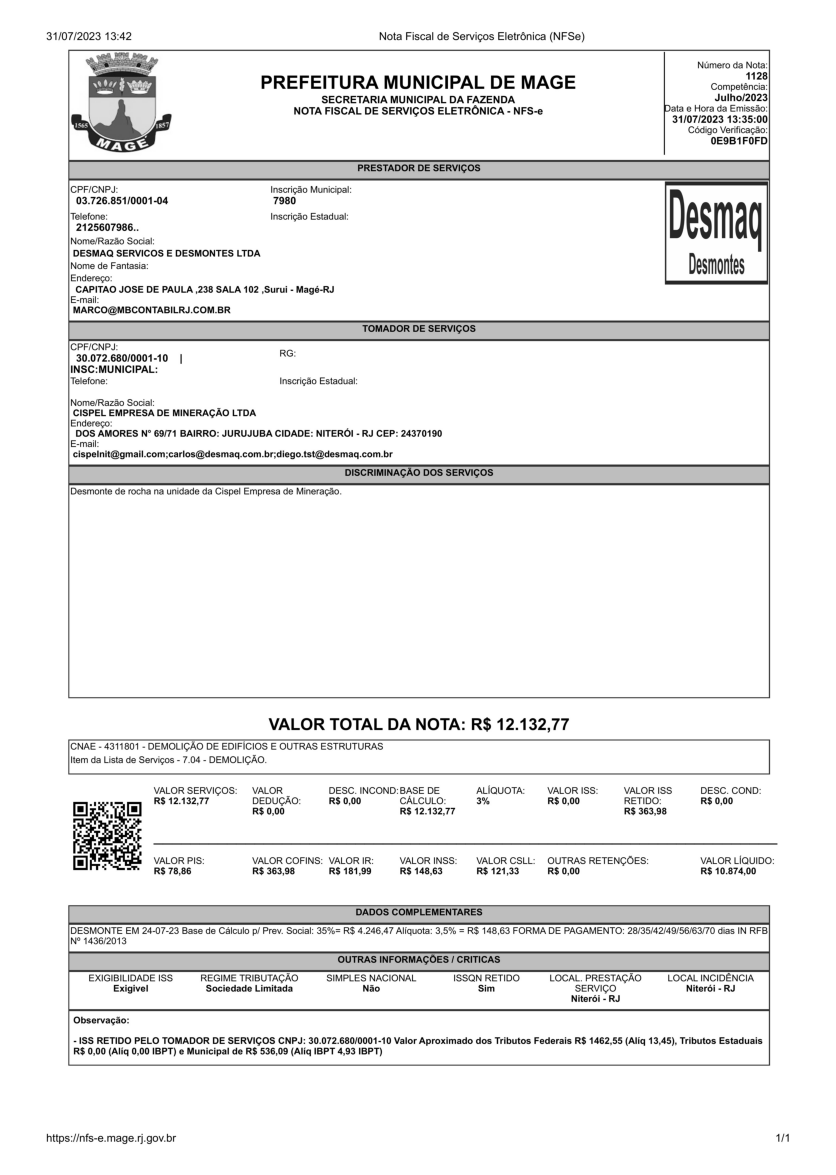

In [88]:
plt.figure(figsize=(15, 15)) 
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
    # Determine as colunas de coordenadas a serem usadas
    x0_col, y0_col, x1_col, y1_col = ('x0_p', 'y0_p', 'x1_p', 'y1_p') if is_searchable else ('x0', 'y0', 'x1', 'y1')

In [131]:
color_mapping = {
    "red": (1, 0, 0),
    "purple": (0.5, 0, 0.5),
    "orange": (1, 0.647, 0),
    "green": (0, 0.5, 0.196),
    "blue": (0, 0, 1),
    "yellow": (1, 1, 0),
}


def draw_boxes(image_np, df, modelo, draw_types=None):
    plt.figure(figsize=(25, 25))
    plt.imshow(image_np)
    plt.axis('off')
    
    # Filtrar baseado no modelo e nos tipos de "boxes" a serem desenhados
    filtered_df = df[df['model'] == modelo]
    if draw_types:
        filtered_df = filtered_df[filtered_df['type'].isin(draw_types)]
    
    for index, row in filtered_df.iterrows():
        x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
        
        color = color_mapping.get(row['color'], 'black')
        
        # Adicionando o retângulo
        plt.gca().add_patch(Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor=color, facecolor='none'))
        
        # Adicionando o rótulo, se existir
        label = str(row['label']) if pd.notnull(row['label']) else None
        if label:
            plt.text(x0 + 10, y0 - 15, label, color=color, fontsize=10)
            plt.text(x0 + 20, y0 + 55,(x0, y0, x1, y1), color='black', fontsize=7)

    
    plt.show()


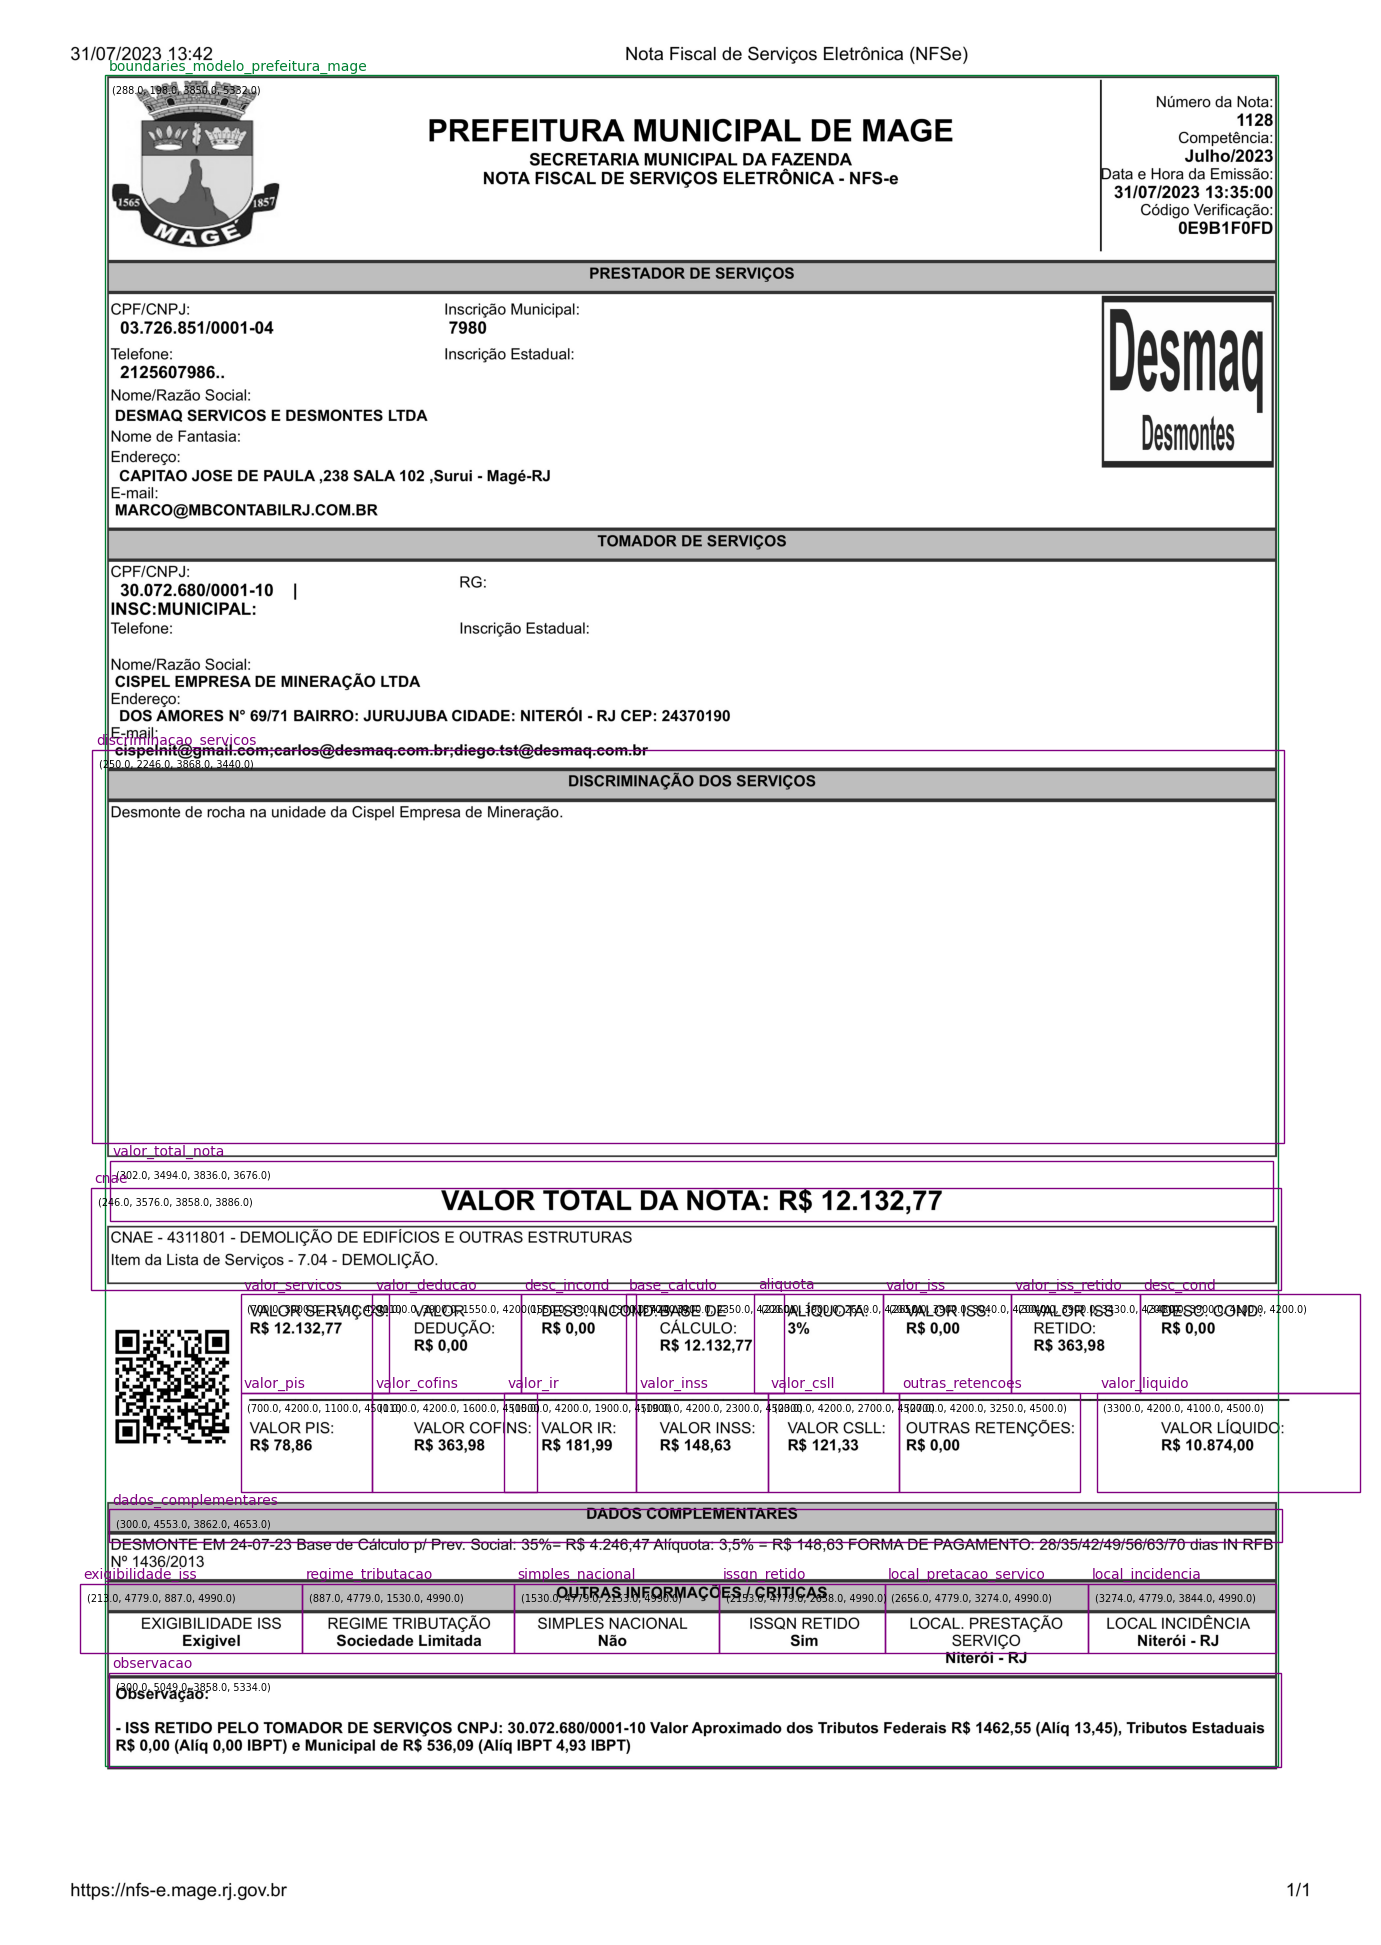

In [130]:
draw_boxes(image_np, frames_nf_v4_df, 'MAGE', draw_types=['boundaries', 'field_box'])

In [92]:
import cv2
import numpy as np

# Variáveis para armazenar as coordenadas do retângulo
startX, startY, endX, endY = -1, -1, -1, -1
drawing = False

def draw_rectangle(event, x, y, flags, param):
    global startX, startY, endX, endY, drawing

    # Se o botão esquerdo do mouse for pressionado, comece a desenhar o retângulo
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        startX, startY = x, y

    # Se o botão esquerdo do mouse for solto, finalize o retângulo
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        endX, endY = x, y
        cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Carregue sua imagem como um array NumPy
img = np.copy(image_np) # Substitua 'image_np' pelo seu array NumPy da imagem

# Crie uma janela e atribua a função de callback
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_rectangle)

while True:
    # Exibe a imagem
    cv2.imshow("Image", img)
    
    # Se a tecla 'q' for pressionada, saia do loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Fecha todas as janelas OpenCV
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to target thread (0x55d6a1e503d0)

QObject::moveToThread: Current thread (0x55d6a1e503d0) is not the object's thread (0x55d6a1e67310).
Cannot move to tar

KeyboardInterrupt: 

## Outros

In [ ]:
# Esta e o principio da melhor funcao do mundo - SIM ELA E MAS PRECISA FICAR AQUI?
def extracao_pipeline(qualquer_df, fase, atividade, status):
    
    linhas_analise = []
    bloco_1_list = []
    bloco_2_list = []
    bloco_3_list = []
    imagens_list = []  
    new_data = [] 
    
    pre_processo = ['nro_nota', 'competencia', 'dt_hr_emissao', 'codigo_verificacao', 'ajustar_nome', 'split_paginas', 'ajustar_imagem', 'buscar_nome_prefeitura', 'enviar_canceladas', 'enviar_listagens']
    
    time_now = cron.timenow_pt_BR()
    
    fase_processo_atual = fase
    atividade_processo_atual = atividade
    status_documento_atual = status
    
    i = 1
    for idx, row in qualquer_df.iterrows():
        message_erro = []
        
        # 1. Mapeamento de informacoes do DF
        document_unique_id = idx
        seq_df = row['seq']
        batch_name = row['batch']
        fase_processo = row['fase_processo']
        nome_atividade = row['nome_atividade']
        status_documento = row['status_documento']
        original_file_name = row['original_file_name']
        file_directory = row['directory']
        level = row['level']
        d_type = row['level']
        document_type = row['document_type']
        pdf_pesquisavel = row['pdf_pesquisavel']
        one_page_doc = row['one_page']
        modelo = row['modelo']
        
        prefeitura = row['prefeitura']
        
        parent_document_unique_id = row['parent_document_unique_id']
        file_path = row['file_path']
        file_hash = row['file_hash']
        
        # 2. Busca modelo
        if (not status_documento == 'NAO_PROCESSAR') or (not document_type == 'outros') or (not one_page_doc == True):
            
            if atividade_processo_atual == 'extracao_prestador':
            #print(f' 1 - seq: {seq_df} | file: {original_file_name} |status_documento: {status_documento} pdf_pesquisavel: {pdf_pesquisavel}\n')
                if status_documento == status_documento_atual:
         
                    print(f'seq_df: {seq_df} status_documento: {status_documento} | modelo: {modelo:>20} | file: {original_file_name:>40} | prefeitura: {prefeitura:>55} | {pdf_pesquisavel}\n')
                    
                    result_list = []
                    
                    dfcnpj_prestador = {}
                    dfincricao_prestador = {}
                    dfdados_prestador = {}
                        
                    doc2convert = original_file_name
                    section = "2. PRESTADOR DE SERVIÇO"
                    modelo = 'SAO_PEDRO_SUPERMIX'
                    f_tipo = 'frame'
                    
                    dfcnpj_prestador, dfincricao_prestador, dfdados_prestador, textoextraido  = processar_dados_dados_documentos(row, original_file_name, file_path, pdf_pesquisavel, section, modelo, f_tipo)
                    
                    print(f'\n {dfcnpj_prestador}\n{dfincricao_prestador}\n{dfdados_prestador}\n')
                    
               
      


                i += 1
              
    return textoextraido

In [ ]:
    secao = "6. CNAE e Item da Lista de Serviços"
    try:
        nd_data_CNAE = {}
        nd_data_CNAE['secao'] = secao
        f_frame_name = "4_frame_cnae_itens_servico"   
        Texto_extraido = executa_model_frame(model, secao, f_frame_name)
        text_splited = Texto_extraido.split('\n')
        # Processando CNAE
        cnae_line = [line for line in text_splited if 'CNAE' in line][0]
        cnae_number = int(extract_number(cnae_line))
        cnae_value = cnae_dict.get(cnae_number, "Valor não encontrado")
        if cnae_value == 'Valor não encontrado':
            cnae_value = processa_cnae_outros(cnae_line)
            cnae_value = cnae_value.upper()
            nd_data_CNAE['cnae'] = cnae_value
        else:
            cnae_value = cnae_value.upper()
            cnae_value = str(cnae_number) + " - " + cnae_value
            nd_data_CNAE['cnae'] = cnae_value
            nd_data_CNAE['item_lista_servicos'] = item_servico_value
    except Exception as e:
        print(f"Erro busca cnae: {e}")    

    try:
        item_servico_line = [line for line in text_splited if 'Item da Lista de Serviços' in line][0]
        item_servico_number = float(extract_number(item_servico_line))
        item_servico_value = item_servico_dict.get(item_servico_number, "Valor não encontrado")
        item_servico_value = item_servico_value.upper()
        item_servico_value = str(item_servico_number) + " - " + item_servico_value
        nd_data_CNAE['item_lista_servicos'] = item_servico_value
    except Exception as e:
        print(f"Erro busca Itens de servico: {e}")  